# Project Report: Spatial and temporal pattern of light-duty vehicles' emission behavior in New York City
__author: "Sevin Mohammadi sm4894"__

## Motivation
The contribution of the transportation system to air pollution is not negligible. A large part of this emission contribution comes from gasoline fuel vehicles. Understanding vehicular emission behavior can help policymakers to leverage the the existing strategies, mitigate the fuel consumption and emission rate and thus have a clean air. with analysing GPS trajectory data, one can extract useful information regarding spatial and temporal vehicular emission in a city. In this project, I aim to analyze the light-duty vehicle trajectory data set to present new insights regarding the spatial and temporal pattern of vehicular emission in new york city.   
## Data
The GPS trajectoriy data set used for this projec is given by the New York City Department of Transportation (NYC-DOT), and it belongs to the New York City Department of Citywide Administrative Services (NYC-DCAS). The data was collected by 27,000 city owned fleet of vehicles for one year and four months in 2015 and 2016. Data sampling rate is 30 seconds and consists of a timestamp, location (latitude and longitude), and speed.The data size is above 200 million rows of GPS records.
## Method
### Data Processing
The GPS records usually are noisy especially in metropolitan areas where the high rise buildings blocks the sattelite signals and cause error in GPS location records. To this end, using map matching algorithms, the GPS points are projected to the best nearest segment candidate. After map matching,  roadway segment id has been added to the GPS trajectory data set, i.e., a segment id has been assigned to each GPS record and these ids are identical to the roadway segment ids presented at New York city shape file. Therefore, trajectory of each vehcile consists of a sequence of segments in each of which the average speed of vehicle speed can be calculated. 
#### Emission
After calculating vehicles average speed at each roadway segment, the emission is calulated using COPERT model. For this project, only hot emission is calculated. The COPERT model for calculating hot emission is as follows [1]:

$$ Q_{ij} = q_{i,j,k} l_j $$

where $Q_{ij} (g)$ and $q_{i,j,k} (g/km)$ are the emission and hot emission factor of pollutant type $k$ generetaed by vehicle $i$ at segment $j$, respectively. $l_j$ is the segment length which are available in New York City shapefile.
The hot emission factor of each pollutant can be calculated as below:

$$q_{i,j,k} = \frac{\alpha_kv_{i,j}^2 + \beta_kv_{i,j} + \lambda_k}{\epsilon_kv_{i,j}^2 + \zeta_kv_{i,j} + \eta_k}$$

where the $v_{i,j} (km/h)$ is the average speed of vehicle i at segment j. The parameters values are presented at the table below [1].


|$k$|$\alpha_k$|$\beta_k$|$\lambda_k$|$\epsilon_k$|$\zeta_k$|$\eta_k$ 
|:-|:- | :- | :- | :- | :-|:-
|CO|0.00|-0.033|5.11|0.002|-0.529|37.51 
| NOx|0.00 | -0.009 | 0.577 | 0 | 0 | 5.43 

The raw data is stored in Postgres server, thereby, all emission calculations has been done in SQL and the aggregated emissions per segment are exported and saved as csv file which are loaded below for furthur spatial analysis. 

## Load required libraries

In [213]:
require(gstat)
library(gstat)
library(sp)
data(meuse)
library(devtools)
library(maps)
library(raster)
require(rgdal)
library(rgdal)
library(sp)
library(rgeos)

## Read emission data - exclude outliers - show the distibution

In [214]:
emissionData <- read.table("emission_mn.txt", header = TRUE,sep = ",")
str(emissionData)
emissionData = subset(emissionData,total_emission>0)
str(emissionData)

'data.frame':	19689 obs. of  4 variables:
 $ X             : int  0 1 2 3 4 5 6 7 8 9 ...
 $ x             : int  978388 978638 978638 978638 979466 979522 979522 979522 979522 979715 ...
 $ y             : int  188892 189042 189042 189042 189636 189566 189566 189566 189566 189799 ...
 $ total_emission: num  0.0707 0.0826 0.0826 0.0826 0.015 ...
'data.frame':	19689 obs. of  4 variables:
 $ X             : int  0 1 2 3 4 5 6 7 8 9 ...
 $ x             : int  978388 978638 978638 978638 979466 979522 979522 979522 979522 979715 ...
 $ y             : int  188892 189042 189042 189042 189636 189566 189566 189566 189566 189799 ...
 $ total_emission: num  0.0707 0.0826 0.0826 0.0826 0.015 ...


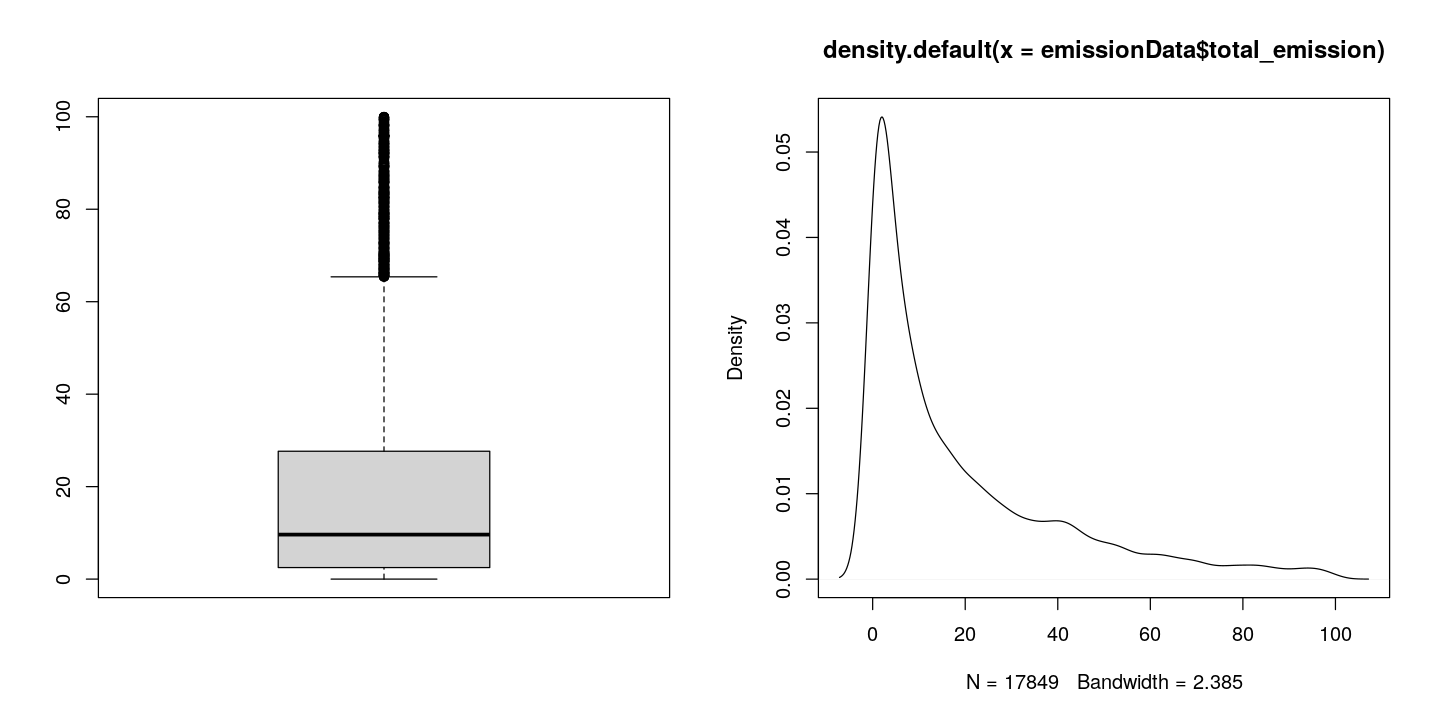

In [215]:
options(repr.plot.width=12, repr.plot.height=6)
emissionData <- subset(emissionData,total_emission<100)
par(mfrow=c(1,2))
boxplot(emissionData$total_emission)
plot(density(emissionData$total_emission))

### Data transformation
The density plot shows that the emissions have positive skew, i.e., they are more toward the lower values. To have a normal distribution, data is transformed by taking the square root of emissions,however, the transformed data is not still quite normal distribution. For this project, it is assumed that transformed data has normal distribution.

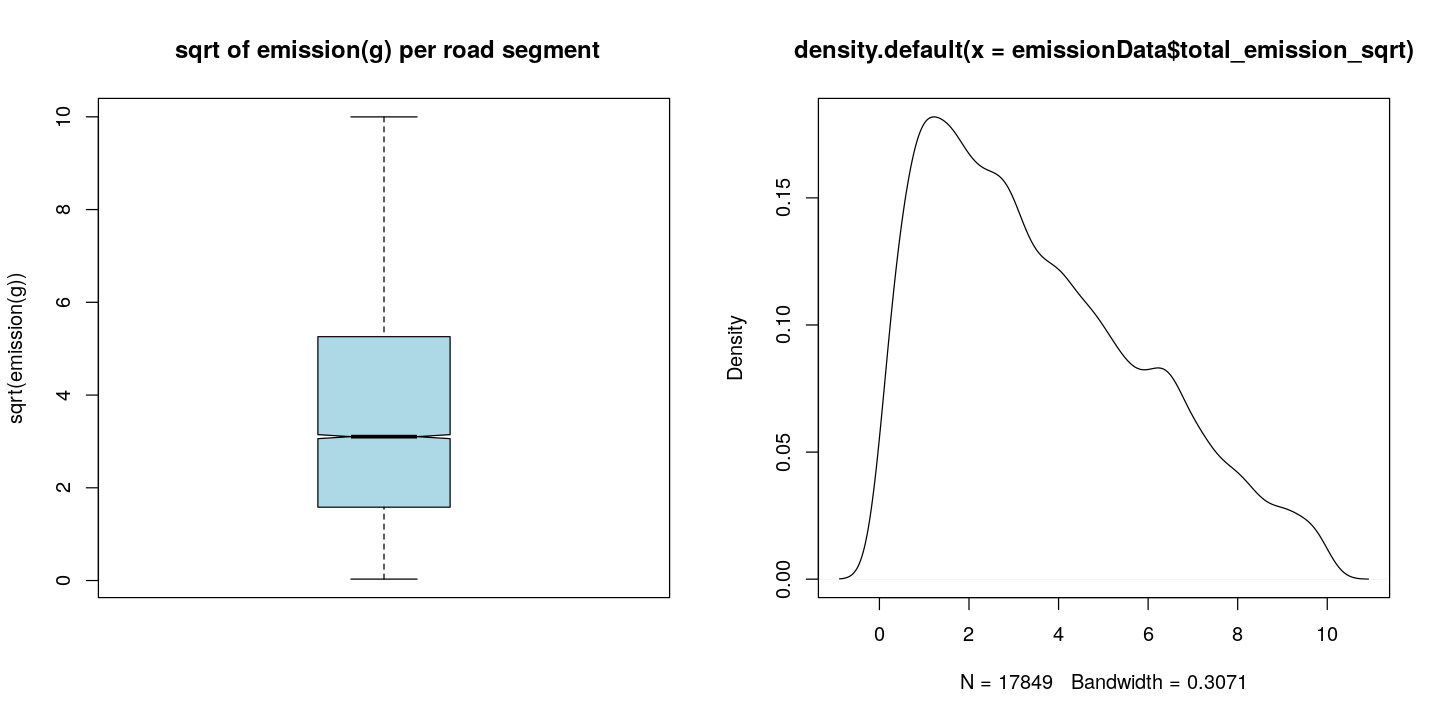

In [216]:
options(repr.plot.width=12, repr.plot.height=6)
par(mfrow=c(1,2))
emissionData$total_emission_sqrt= sqrt(emissionData$total_emission) # let us log transform it and save it in a new variable in the same dataframe
boxplot(emissionData$total_emission_sqrt ,ylab = "sqrt(emission(g))", main = " sqrt of emission(g) per road segment",boxwex = 0.5, col = "lightblue", notch = T)
plot(density(emissionData$total_emission_sqrt))

The vehicular hot emission of each roadway segment has been mapped to its end point. The left plot below shows the locations where data exists. The right plot shows the relative amount of emission compared to the maximum emission. 

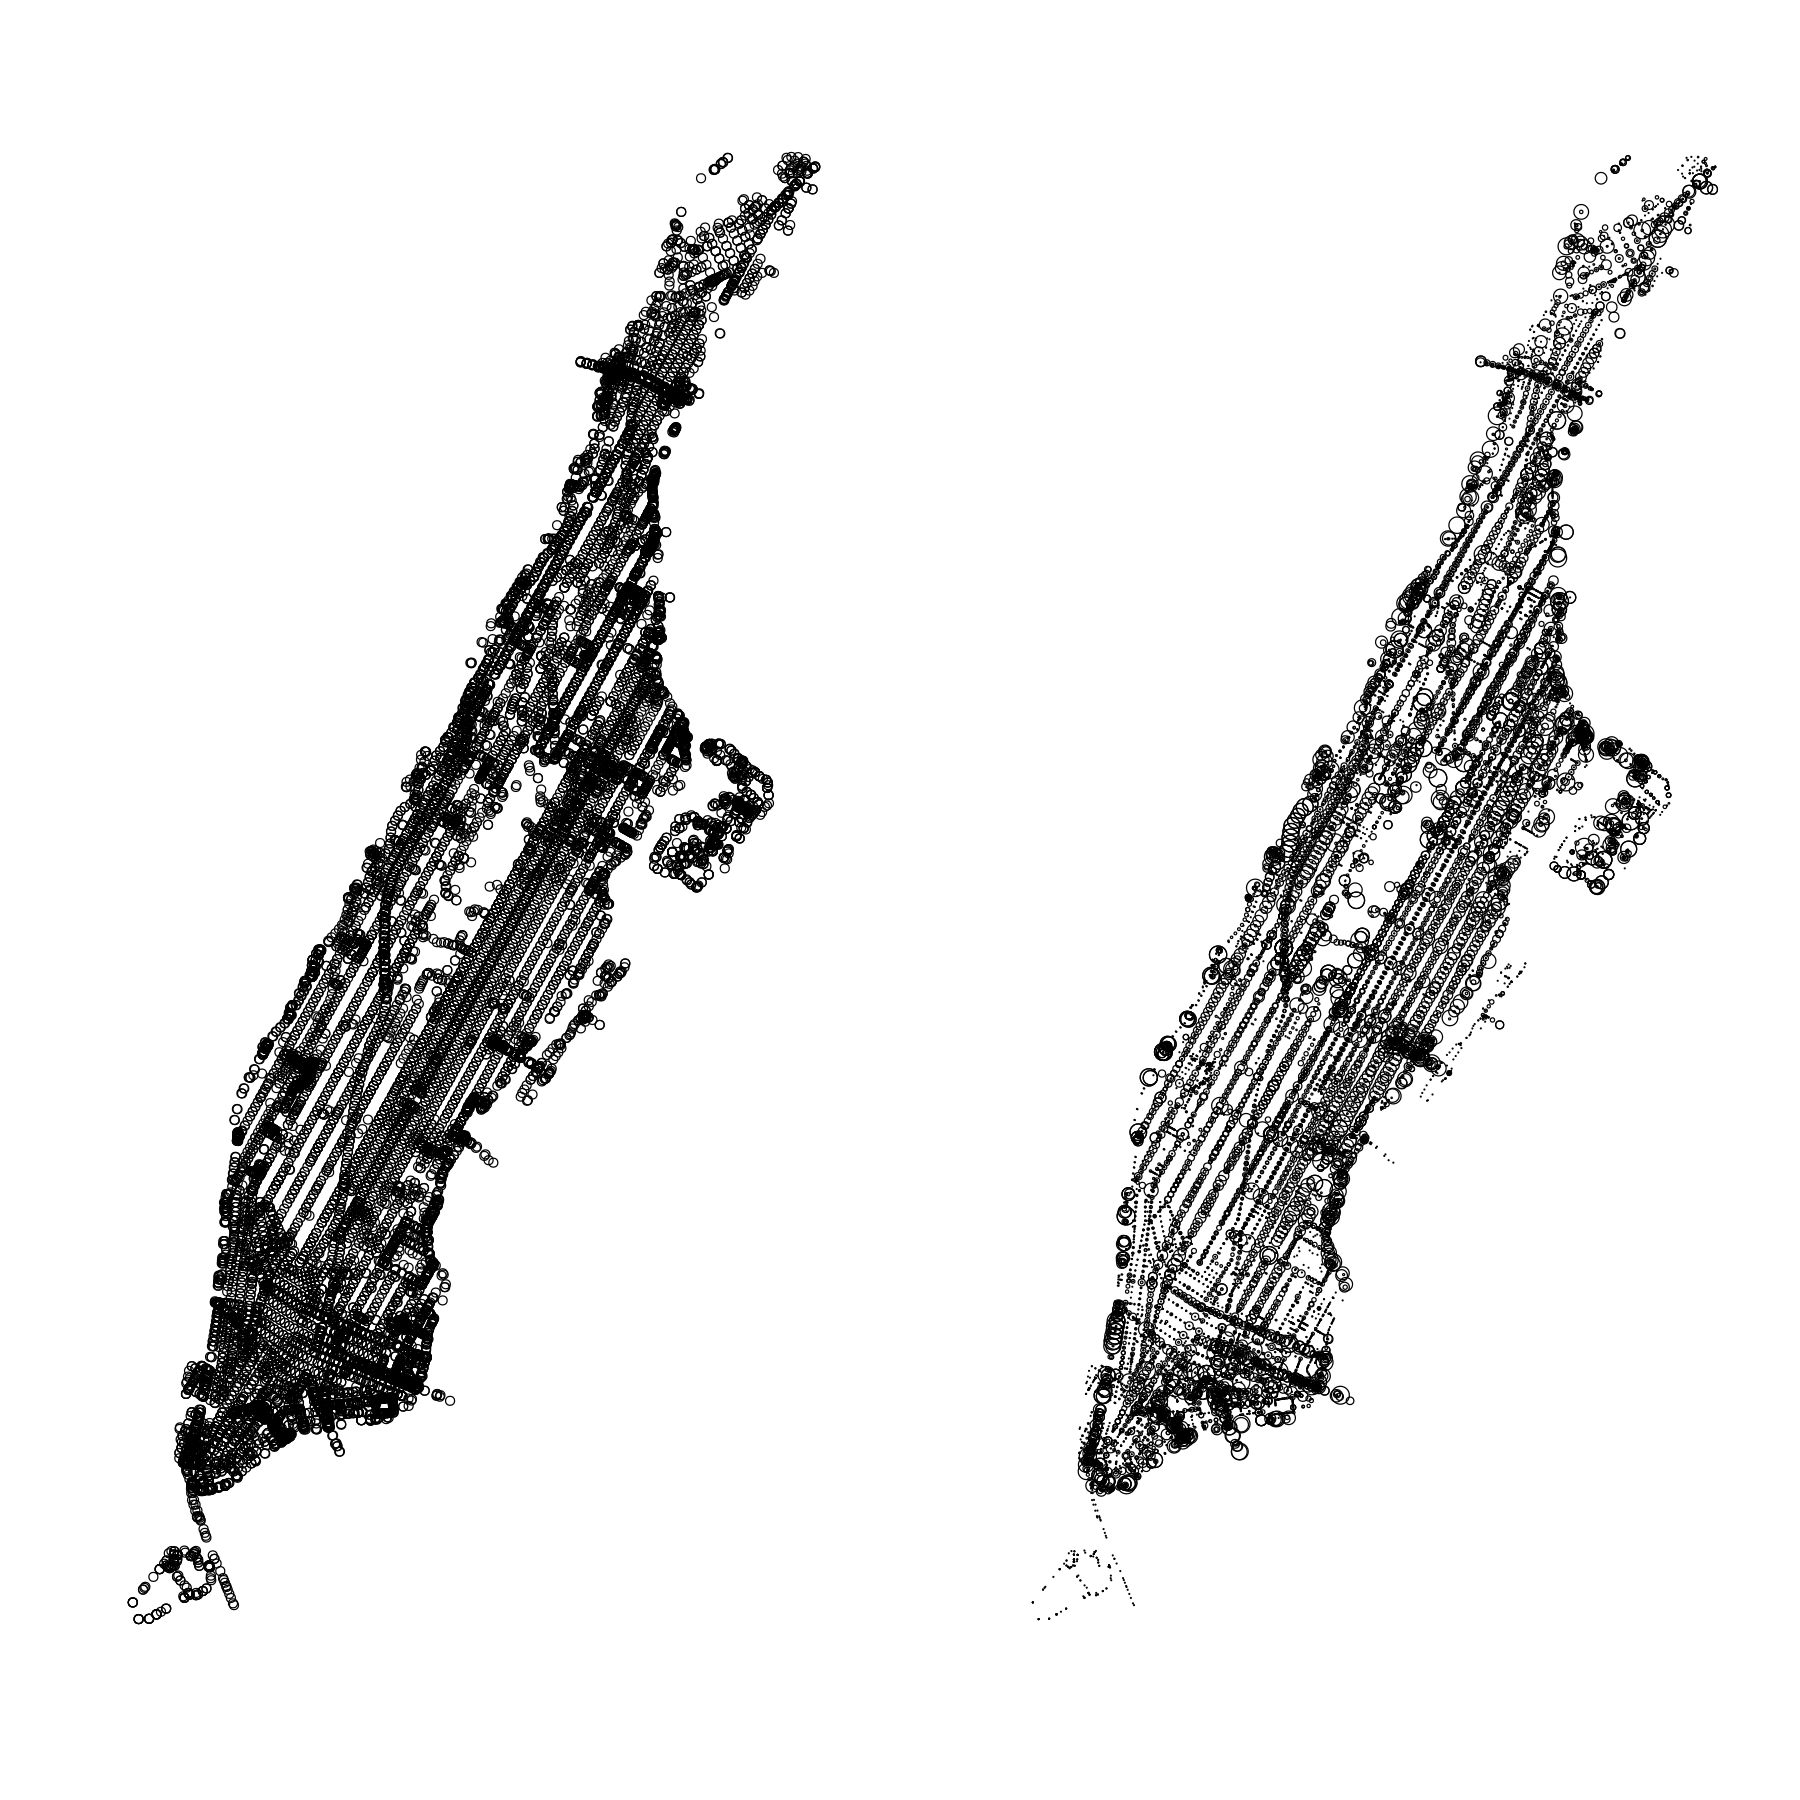

In [217]:
options(repr.plot.width=15, repr.plot.height=15)
par(mfrow=c(1,2))
coordinates(emissionData)=c("x","y")  # this says that the spatial coordinates are the x and y variables
plot(emissionData,asp=1,pch=1) # plots the locations where we have data
plot(emissionData,asp=1,cex=2*emissionData$total_emission/max(emissionData$total_emission),pch=1)

## Spatial Analysis
### Semivariances and Variogram
In this project, semivariograms are calculated to assess the spatial correlation between the spatially distributed point emissions. Semivariograms depict the degree of similarity between neighbors as distance between them increases. Semivariances can be calculated using the equation as follow:
$$ \lambda(h) = \frac{1}{2}E[(z(s_i) - z(s_i+h))^2]$$

where $z(s_i)$ is the value of a spatial random variable $s_i$ and $z(s_i + h)$ is the value of the neighbor random variable $s_i + h$ with $h$ as the distance between two points.
Herein, the sample semivariances are calculated and shown by the variogram plot below. Then, the exponential Variogram has been fitted to the the semivariances.   

np,dist,gamma,dir.hor,dir.ver,id
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
44314,43.82073,3.051349,0,0,var1
40826,151.05351,3.177127,0,0,var1
77096,256.63901,3.721971,0,0,var1
64735,350.45215,4.191462,0,0,var1
79776,453.55874,4.242131,0,0,var1
132006,547.50598,4.357224,0,0,var1
103188,650.08011,4.649355,0,0,var1
138598,753.12823,4.591931,0,0,var1
138714,849.71185,4.908204,0,0,var1


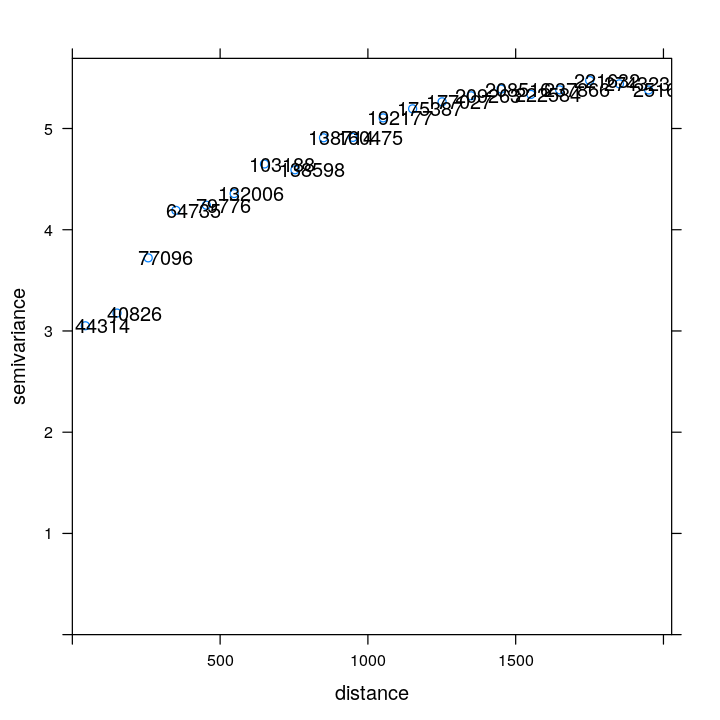

In [218]:
options(repr.plot.width=6, repr.plot.height=6)
(v=variogram(total_emission_sqrt~1, emissionData,cutoff=2000,width=100))
print(plot(v,plot.numbers=T))


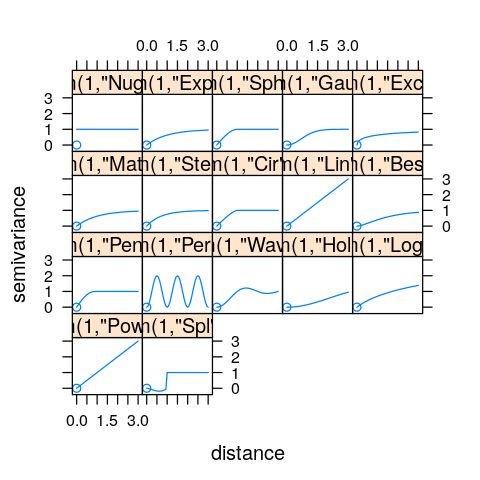

In [219]:
options(repr.plot.width=4, repr.plot.height=4)
print(show.vgms())

### Sample variogram and fitted exponential variogram

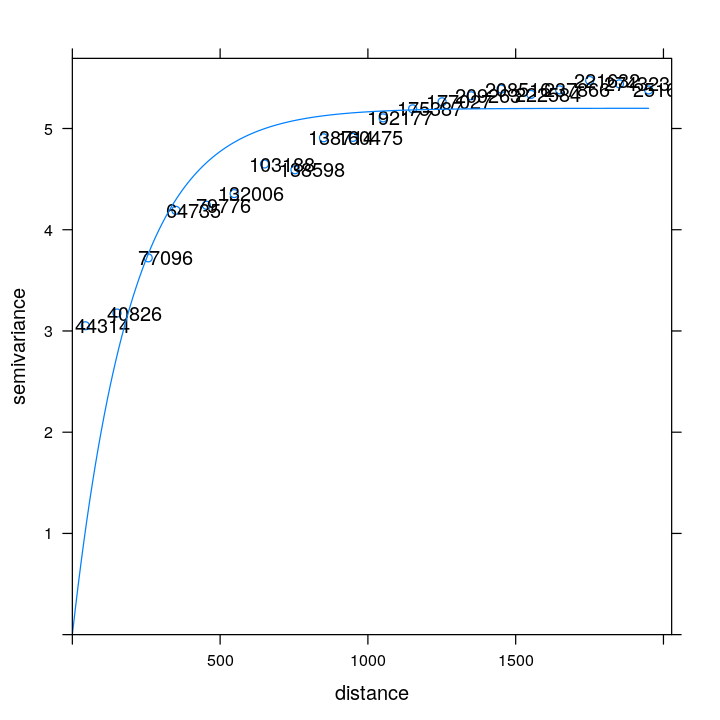

In [220]:
options(repr.plot.width=6, repr.plot.height=6)
vm=vgm(psill=5.2,model="Exp",range=200,nuget=3)  #chose values of sill, range, nugget just to see
print(plot(v,pl=T,model=vm))

,model,psill,range,kappa,ang1,ang2,ang3,anis1,anis2
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Nug,2.879131,0.0000,0.0,0,0,0,1,1
2,Exp,2.901905,761.9352,0.5,0,0,0,1,1


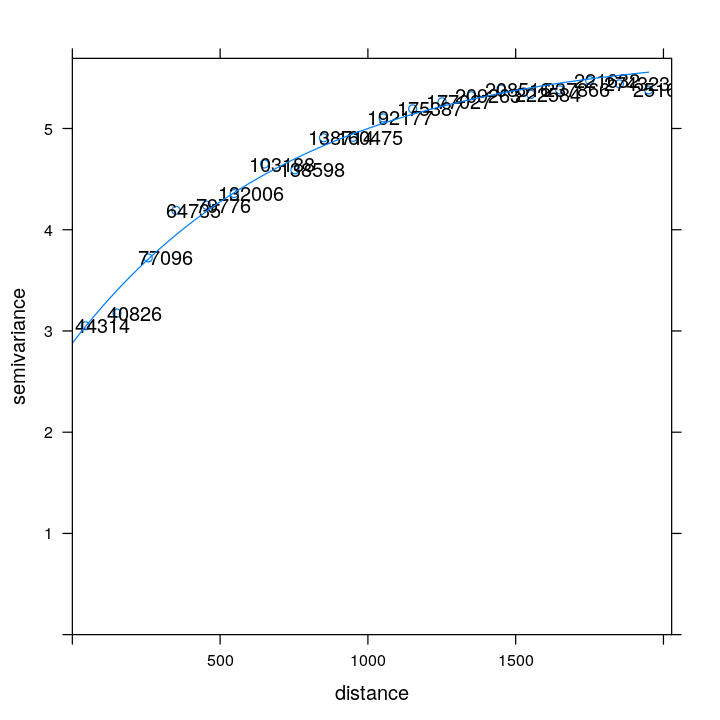

In [221]:
(vmf=fit.variogram(v,vgm(0.12,"Exp",1300,0)))
print(plot(v,pl=T,model=vmf))

## Kriging
After calculating the variograms,the best linear model can be estimated to predict the vehicular emission at the intermediate locations.  The semivariances are used to calculate the weights of the linear estimator. Suppose, $z(x_i)s, i=1,..N$ are the observed values at locations $x_i$s, thus for any new location $x_0$ the value of $z(x_0)$ can be calculated as follows [2]:
$$Z(x_0) = \sum_{i=1}^{N} = \lambda_iz(x_i)$$
where $\lambda_i$s are the weights that minimizes the the error variance of the predicted model. $\lambda_i$s can be computed through the equations below:
$$\sum_{i=1}^{N} = \lambda_i\gamma(x_i-x_j) + \psi(x_o) = \gamma(x_j-x_0) $$
$$\sum_{i=1}^{N}\lambda_i = 1$$
where $\gamma(x_i-x_j)$ is the semivariance between $x_i$ and $x_j$, $\gamma(x_j-x_0)$ is the semivariance between $x_j$ and the target location $x_0$, and $\psi(x_o)$ is the lagrange multiplier.
To implement the kriging, first, the area needs to be gridded into cells. To this end, the polygon of the Manhattan borough and the Central park needs to be loaded.

### Load Central Park polygon

In [222]:
nycParks <- readOGR('ARCHIVED - Parks Properties','geo_export_32bd16dd-fddc-4ca1-b993-2c7c48c745cc')
centralPark = subset(nycParks, global_id=="{9B51C8B1-5896-4A38-BAC1-FD5E6DFD83D6}")
TcentralPark = spTransform(centralPark, CRS("+proj=lcc +lat_1=40.66666666666666 +lat_2=41.03333333333333 +lat_0=40.16666666666666 +lon_0=-74 
        +x_0=300000 +y_0=0 +ellps=GRS80 +datum=NAD83 
        +to_meter=0.3048006096012192 +units=us-ft +no_defs ")) # To convert it to WGS84

OGR data source with driver: ESRI Shapefile 
Source: "/home/sevin/Desktop/projects/emission/code/ARCHIVED - Parks Properties", layer: "geo_export_32bd16dd-fddc-4ca1-b993-2c7c48c745cc"
with 2015 features
It has 35 fields


NOTE: rgdal::checkCRSArgs: no proj_defs.dat in PROJ.4 shared files



### Load Manhattan borough polygon

In [223]:
shp <- shapefile("/home/sevin/Desktop/projects/emission/data/nybb_21a/nybb.shp")
mn_shp = shp[1,]
nyshp = spTransform(mn_shp, CRS("+proj=lcc +lat_1=40.66666666666666 +lat_2=41.03333333333333 +lat_0=40.16666666666666 +lon_0=-74 
        +x_0=300000 +y_0=0 +ellps=GRS80 +datum=NAD83 
        +to_meter=0.3048006096012192 +units=us-ft +no_defs ")) # To convert it to WGS84

NOTE: rgdal::checkCRSArgs: no proj_defs.dat in PROJ.4 shared files



### Exclude central park from the Manhattan

In [224]:
nyshp <- gSymdifference(TcentralPark,mn_shp)

Warning message in RGEOSBinTopoFunc(spgeom1, spgeom2, byid, id, drop_lower_td, unaryUnion_if_byid_false, :
"spgeom1 and spgeom2 have different proj4 strings"


### make grid with cell size 1000 (and 500) and plot it

NOTE: rgdal::checkCRSArgs: no proj_defs.dat in PROJ.4 shared files

NOTE: rgdal::checkCRSArgs: no proj_defs.dat in PROJ.4 shared files

NOTE: rgdal::checkCRSArgs: no proj_defs.dat in PROJ.4 shared files



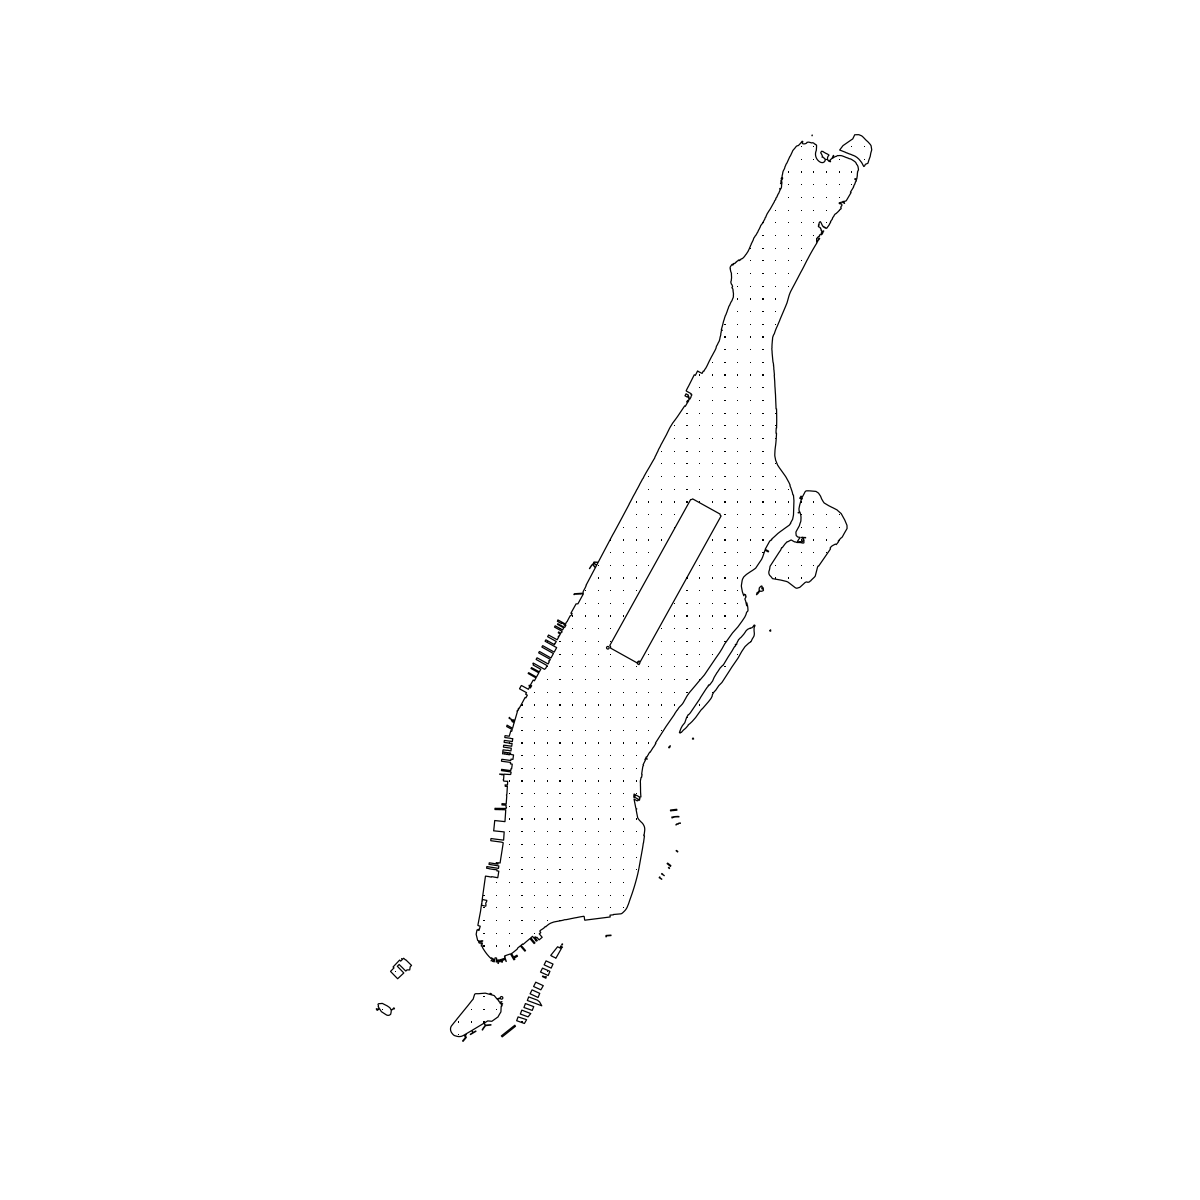

In [226]:
options(repr.plot.width=10, repr.plot.height=10)
grid <- makegrid(nyshp, cellsize = 1000)
grid <- SpatialPoints(grid, proj4string = CRS("+proj=lcc +lat_1=40.66666666666666 +lat_2=41.03333333333333 +lat_0=40.16666666666666 +lon_0=-74 
        +x_0=300000 +y_0=0 +ellps=GRS80 +datum=NAD83 
        +to_meter=0.3048006096012192 +units=us-ft +no_defs ")) #, proj4string = CRS(2263))
grid <- grid[nyshp, ]
plot(nyshp)
plot(grid, pch = ".", add = T)#, 

In [227]:
grid_df <- as.data.frame(grid)
coordinates(grid_df)=c("x1","x2")
gridded(grid_df)=T
#head(grid_df,2)

Warning message in points2grid(points, tolerance, round):
"grid has empty column/rows in dimension 1"
Warning message in points2grid(points, tolerance, round):
"grid has empty column/rows in dimension 2"


### Remove duplicate points (zero distance points to avoid singularity error)

In [228]:
emissionData <- emissionData[-zerodist(emissionData)[,1],]
str(emissionData)

Formal class 'SpatialPointsDataFrame' [package "sp"] with 5 slots
  ..@ data       :'data.frame':	10640 obs. of  3 variables:
  .. ..$ X                  : int [1:10640] 0 3 4 8 12 15 16 17 21 22 ...
  .. ..$ total_emission     : num [1:10640] 0.0707 0.08261 0.01505 0.00642 0.0191 ...
  .. ..$ total_emission_sqrt: num [1:10640] 0.2659 0.2874 0.1227 0.0801 0.1382 ...
  ..@ coords.nrs : int [1:2] 2 3
  ..@ coords     : num [1:10640, 1:2] 978388 978638 979466 979522 979715 ...
  .. ..- attr(*, "dimnames")=List of 2
  .. .. ..$ : chr [1:10640] "1" "4" "5" "9" ...
  .. .. ..$ : chr [1:2] "x" "y"
  ..@ bbox       : num [1:2, 1:2] 977029 188536 1009967 259116
  .. ..- attr(*, "dimnames")=List of 2
  .. .. ..$ : chr [1:2] "x" "y"
  .. .. ..$ : chr [1:2] "min" "max"
  ..@ proj4string:Formal class 'CRS' [package "sp"] with 1 slot
  .. .. ..@ projargs: chr NA


### Ordinary Kriging with cellsize = 1000

[using ordinary kriging]


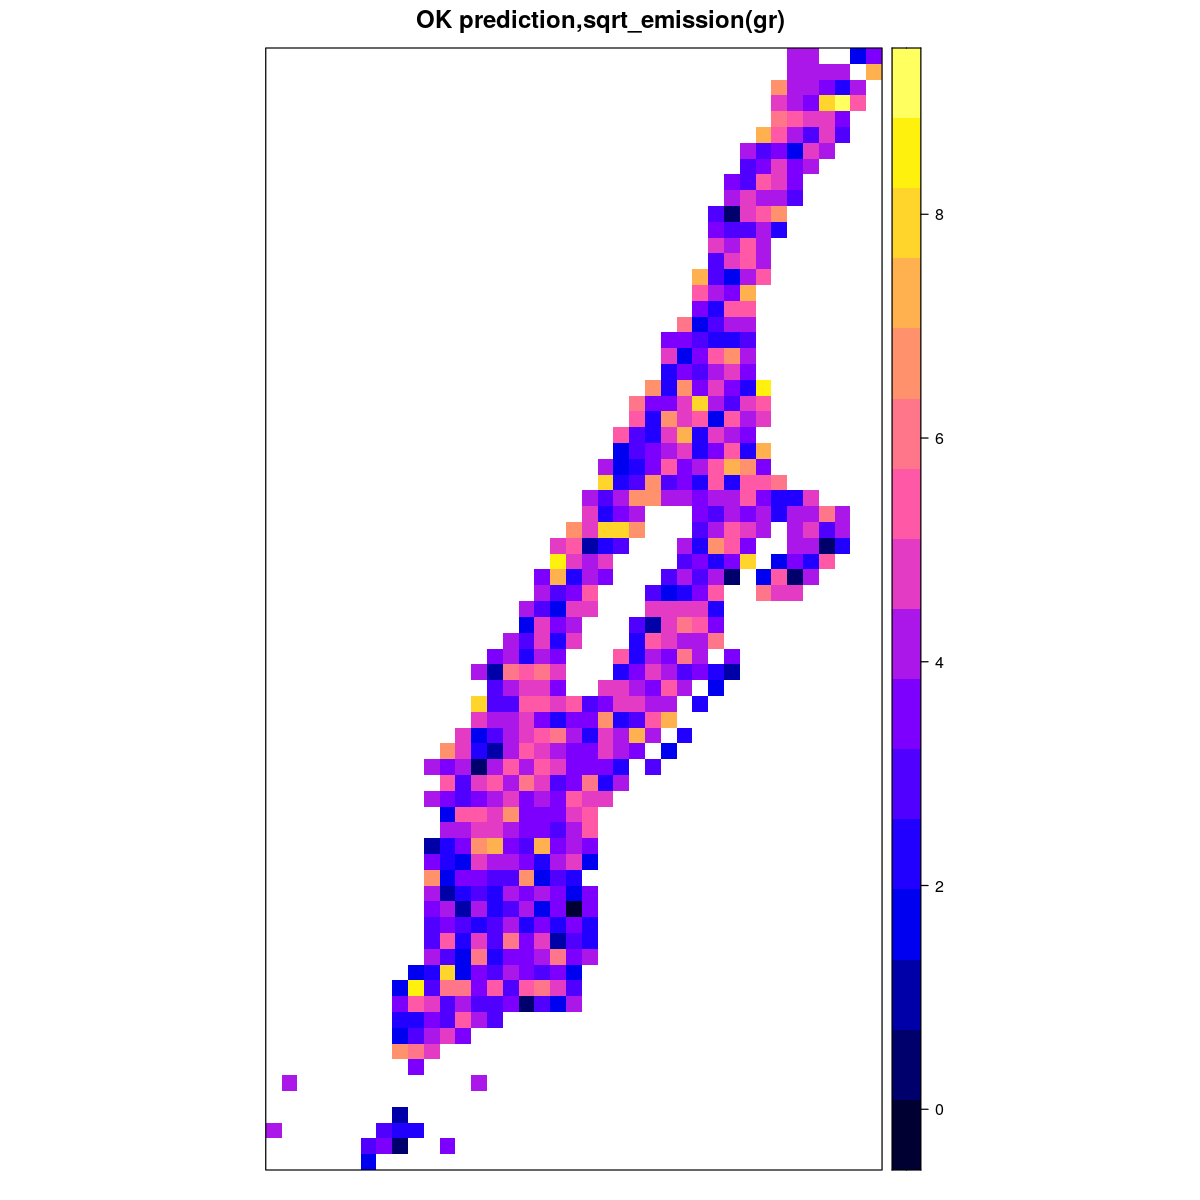

In [230]:
k1000=krige(total_emission_sqrt~1, locations=emissionData,newdata=grid_df,model=vm)
print(spplot(k1000,"var1.pred",asp=1,col.regions=bpy.colors(64),main="OK prediction,sqrt_emission(gr)"))

### Plot spatial variances 

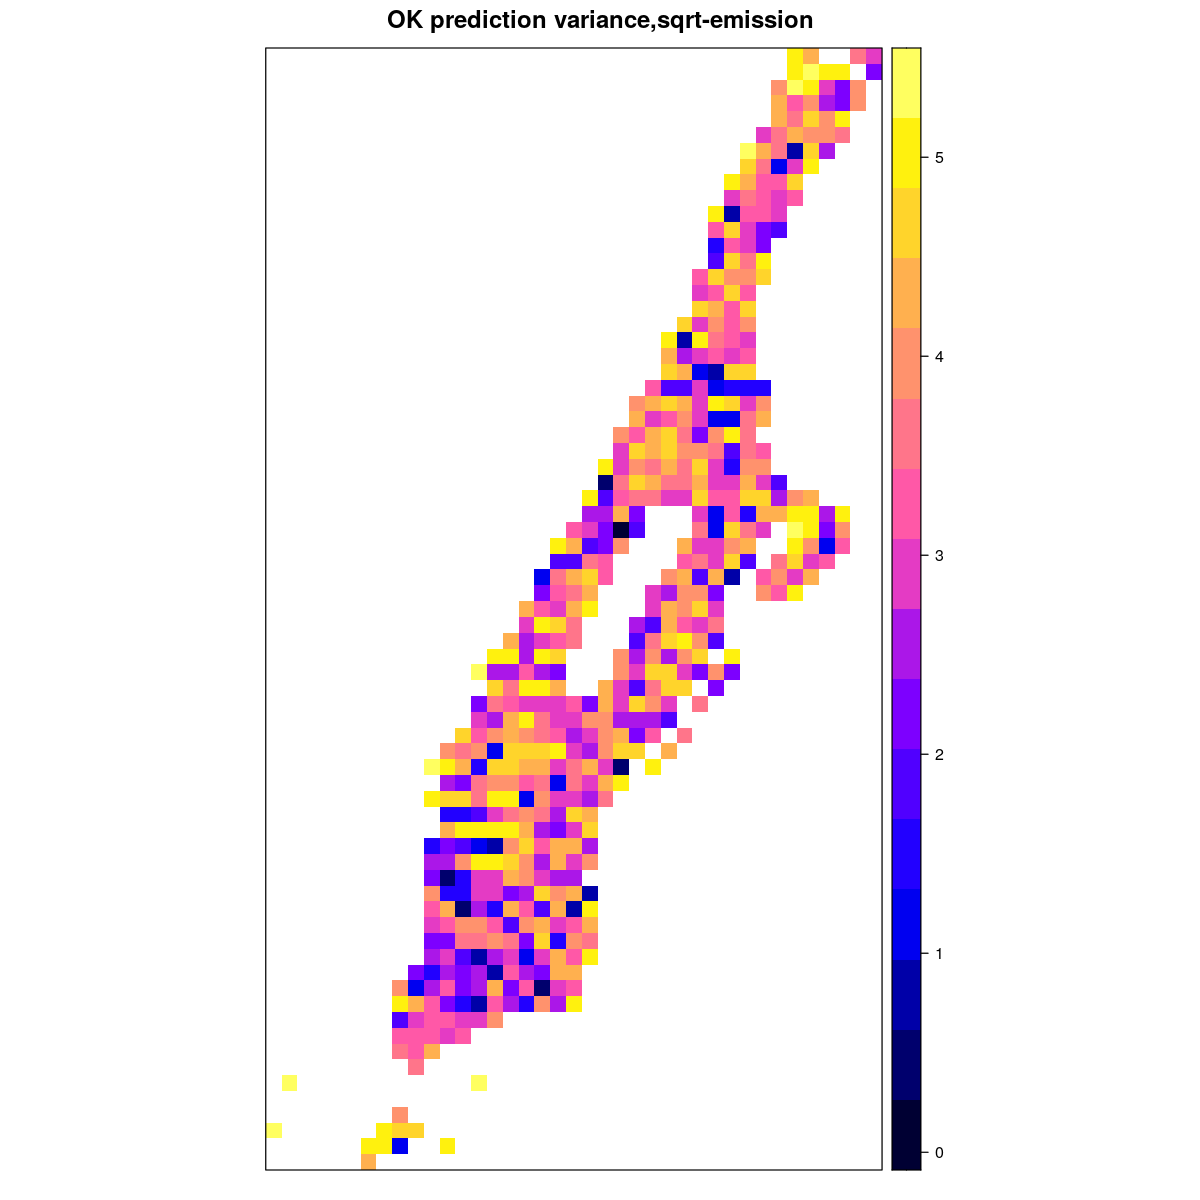

In [231]:
print(spplot(k1000,"var1.var", asp=1,col.regions=bpy.colors(64),main="OK prediction variance,sqrt-emission"))

### Ordinary Krigging with cell size=500

NOTE: rgdal::checkCRSArgs: no proj_defs.dat in PROJ.4 shared files

NOTE: rgdal::checkCRSArgs: no proj_defs.dat in PROJ.4 shared files

NOTE: rgdal::checkCRSArgs: no proj_defs.dat in PROJ.4 shared files

Warning message in points2grid(points, tolerance, round):
"grid has empty column/rows in dimension 1"
Warning message in points2grid(points, tolerance, round):
"grid has empty column/rows in dimension 2"


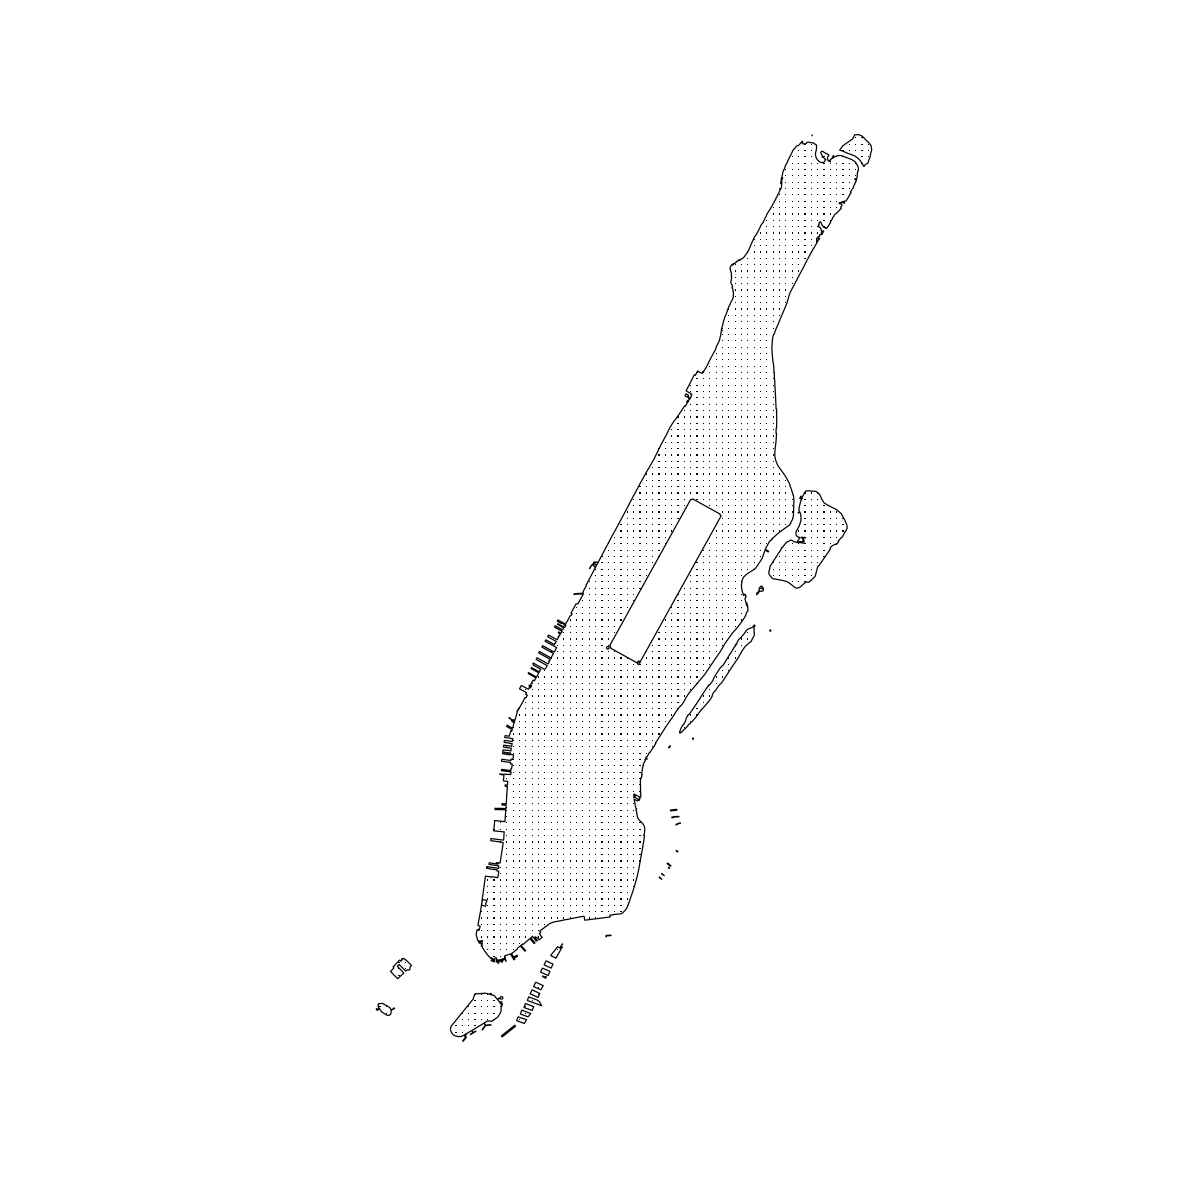

In [232]:
options(repr.plot.width=10, repr.plot.height=10)
grid <- makegrid(nyshp, cellsize = 500)
grid <- SpatialPoints(grid, proj4string = CRS("+proj=lcc +lat_1=40.66666666666666 +lat_2=41.03333333333333 +lat_0=40.16666666666666 +lon_0=-74 
        +x_0=300000 +y_0=0 +ellps=GRS80 +datum=NAD83 
        +to_meter=0.3048006096012192 +units=us-ft +no_defs ")) #, proj4string = CRS(2263))
grid <- grid[nyshp, ]
plot(nyshp)
plot(grid, pch = ".", add = T)#, 
grid_df <- as.data.frame(grid)
coordinates(grid_df)=c("x1","x2")
gridded(grid_df)=T

[using ordinary kriging]


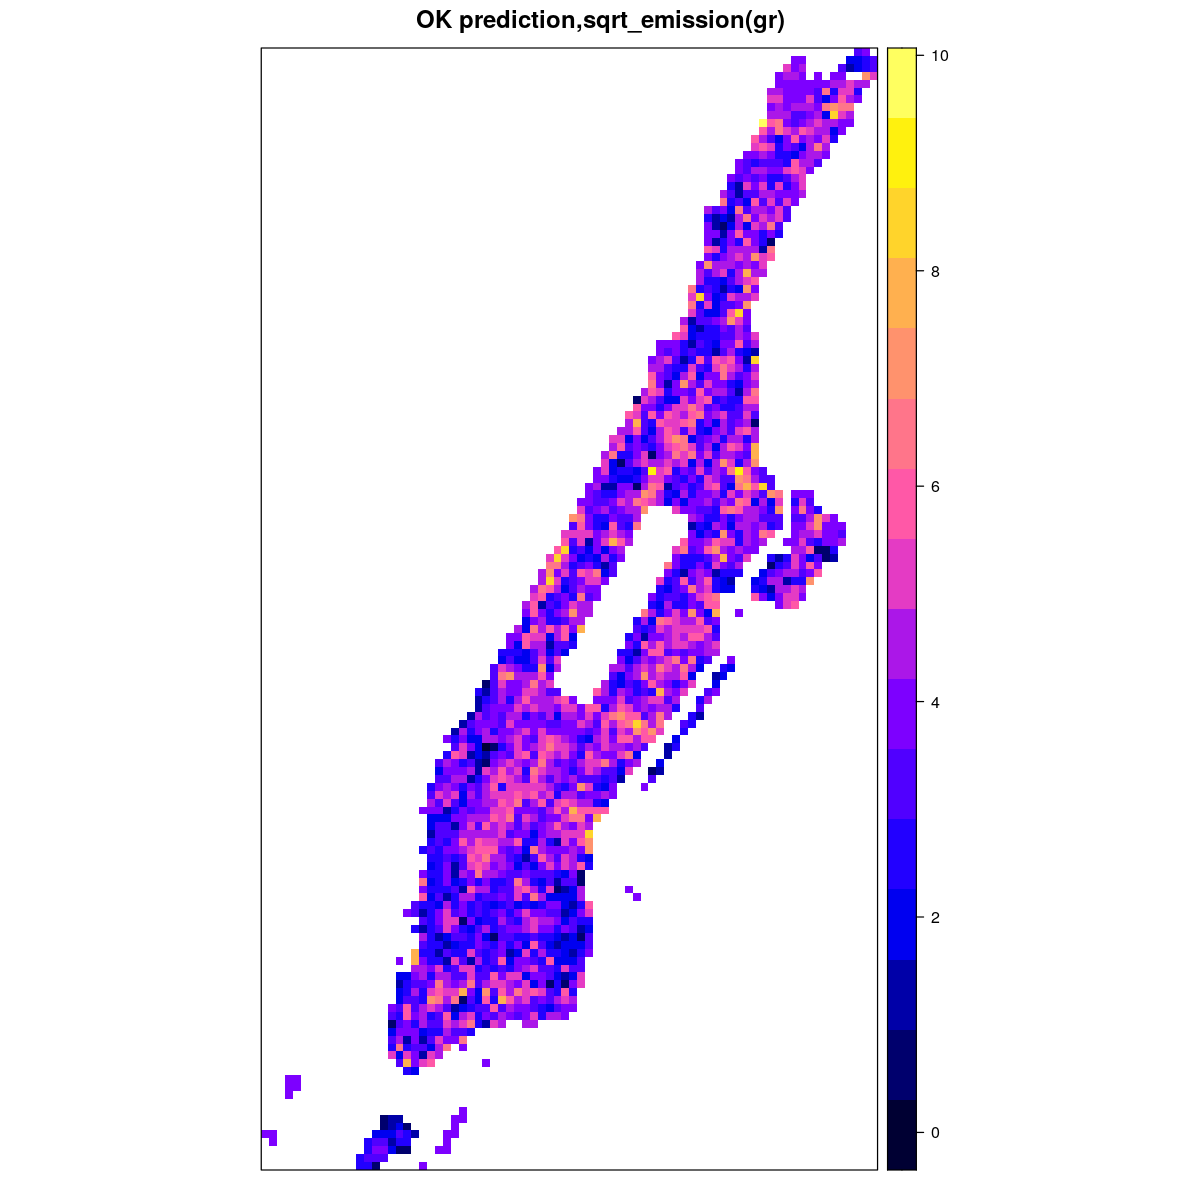

In [233]:
k500=krige(total_emission_sqrt~1, locations=emissionData,newdata=grid_df,model=vm)
print(spplot(k500,"var1.pred",asp=1,col.regions=bpy.colors(64),main="OK prediction,sqrt_emission(gr)"))

### Variance plot

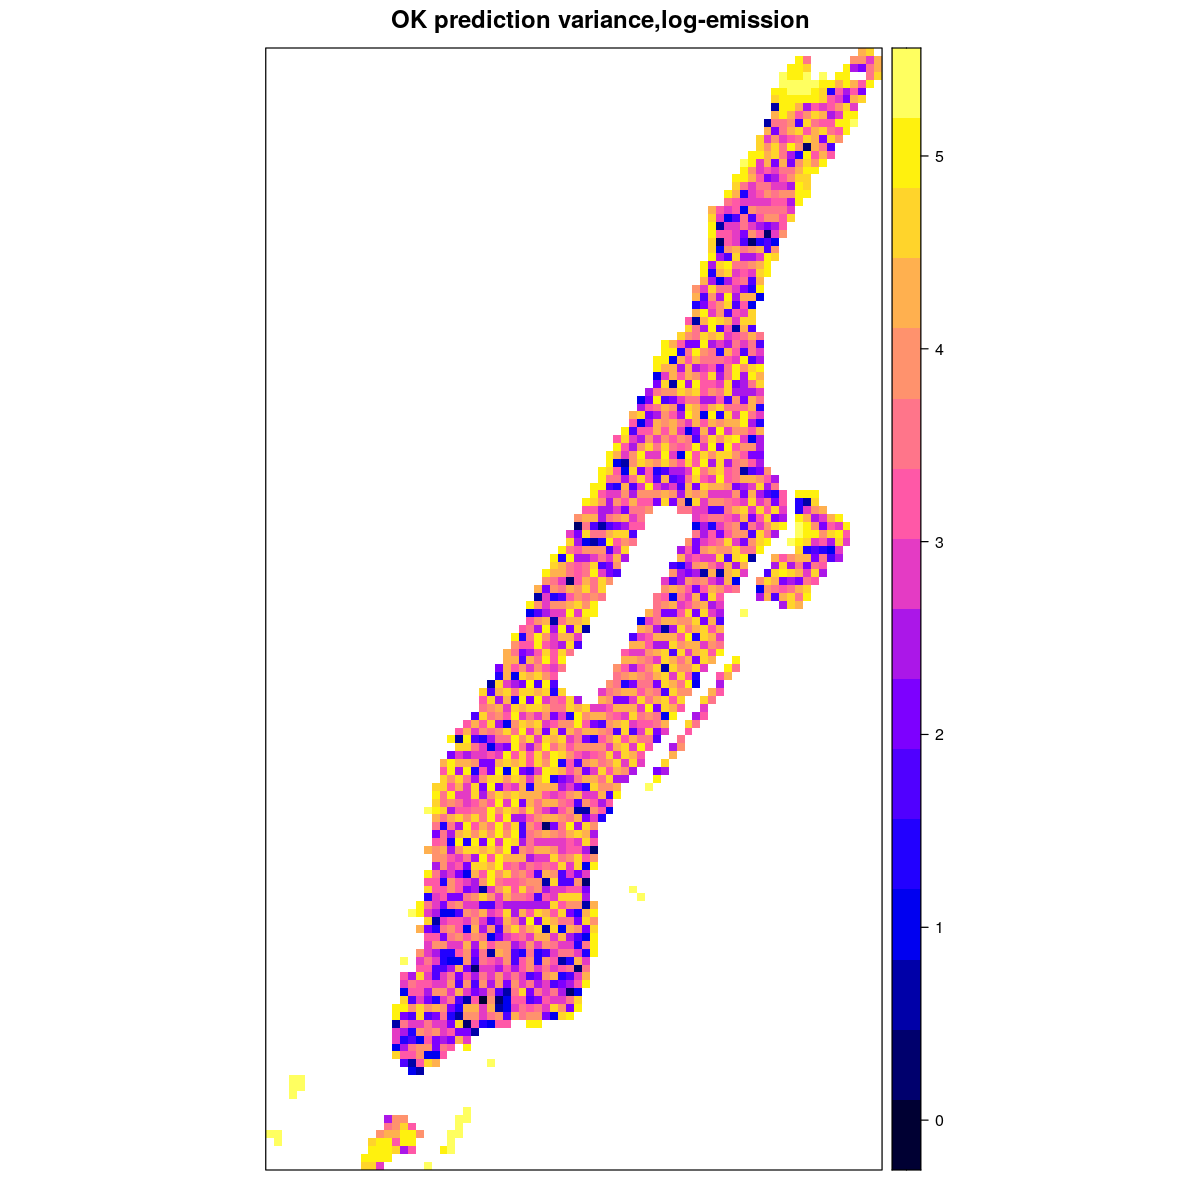

In [181]:
print(spplot(k500,"var1.var", asp=1,col.regions=bpy.colors(64),main="OK prediction variance,sqrt-emission"))

## Prediction of emissions greater than 50 gr
In this step, the variogram and semivariances are calculated for emissions greater than 50 gr. Then best spatial linear model is estimated using the ordinary krigging approach.

In [182]:
emissionData$em_i=(emissionData$total_emission>50)
summary(emissionData$em_i)

   Mode   FALSE    TRUE 
logical    9707     933 

### Calculate the sample semivariances

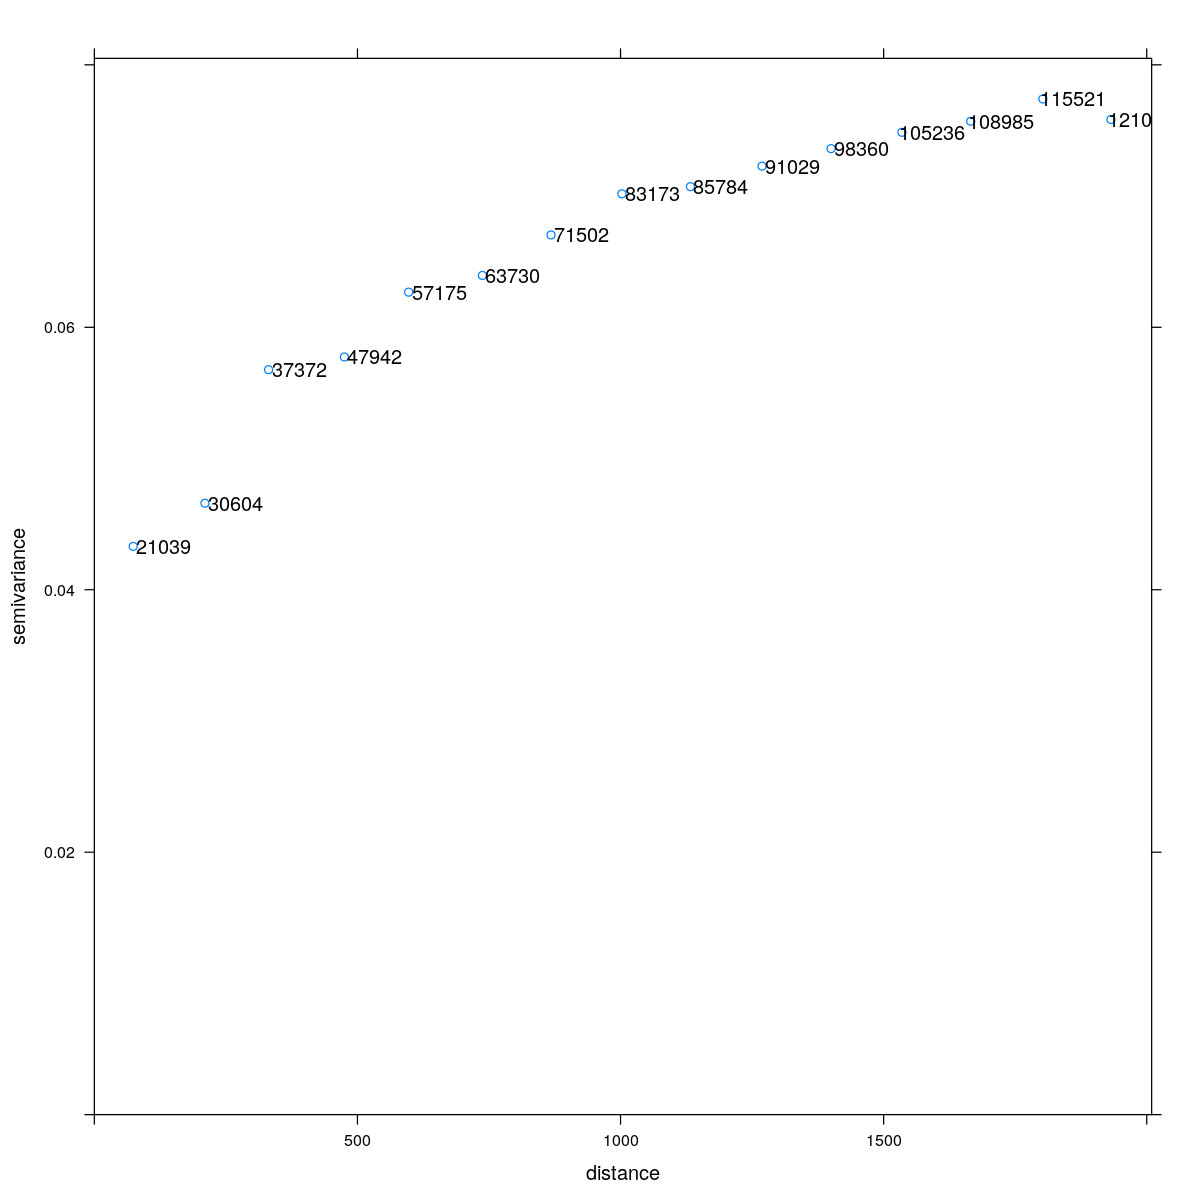

In [183]:
vi=variogram(emissionData$em_i~1, location=emissionData, cutoff=2000)
print(plot(vi,pl=T))

### Fit a circular variogram to the sample semivariances

,model,psill,range,kappa,ang1,ang2,ang3,anis1,anis2
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Nug,0.04059997,0.00,0.0,0,0,0,1,1
2,Cir,0.03305604,1147.08,0.5,0,0,0,1,1


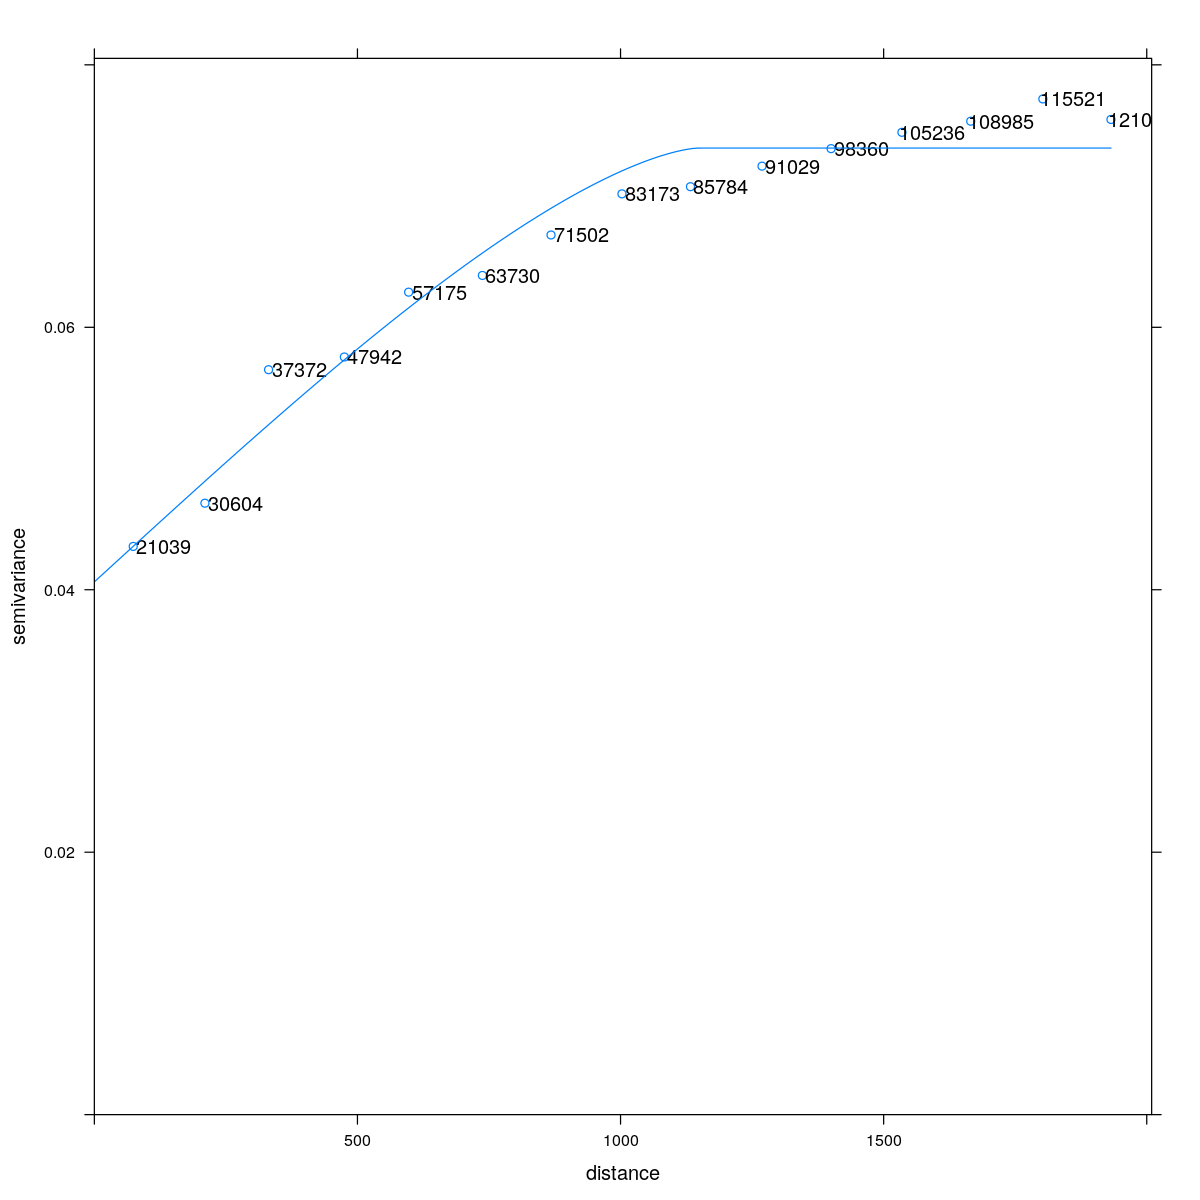

In [184]:
(vimf=fit.variogram(vi,vgm(0.12,"Cir",1300,0)))
print(plot(vi,pl=T,model=vimf))

### Ordinary Kriging

[using ordinary kriging]


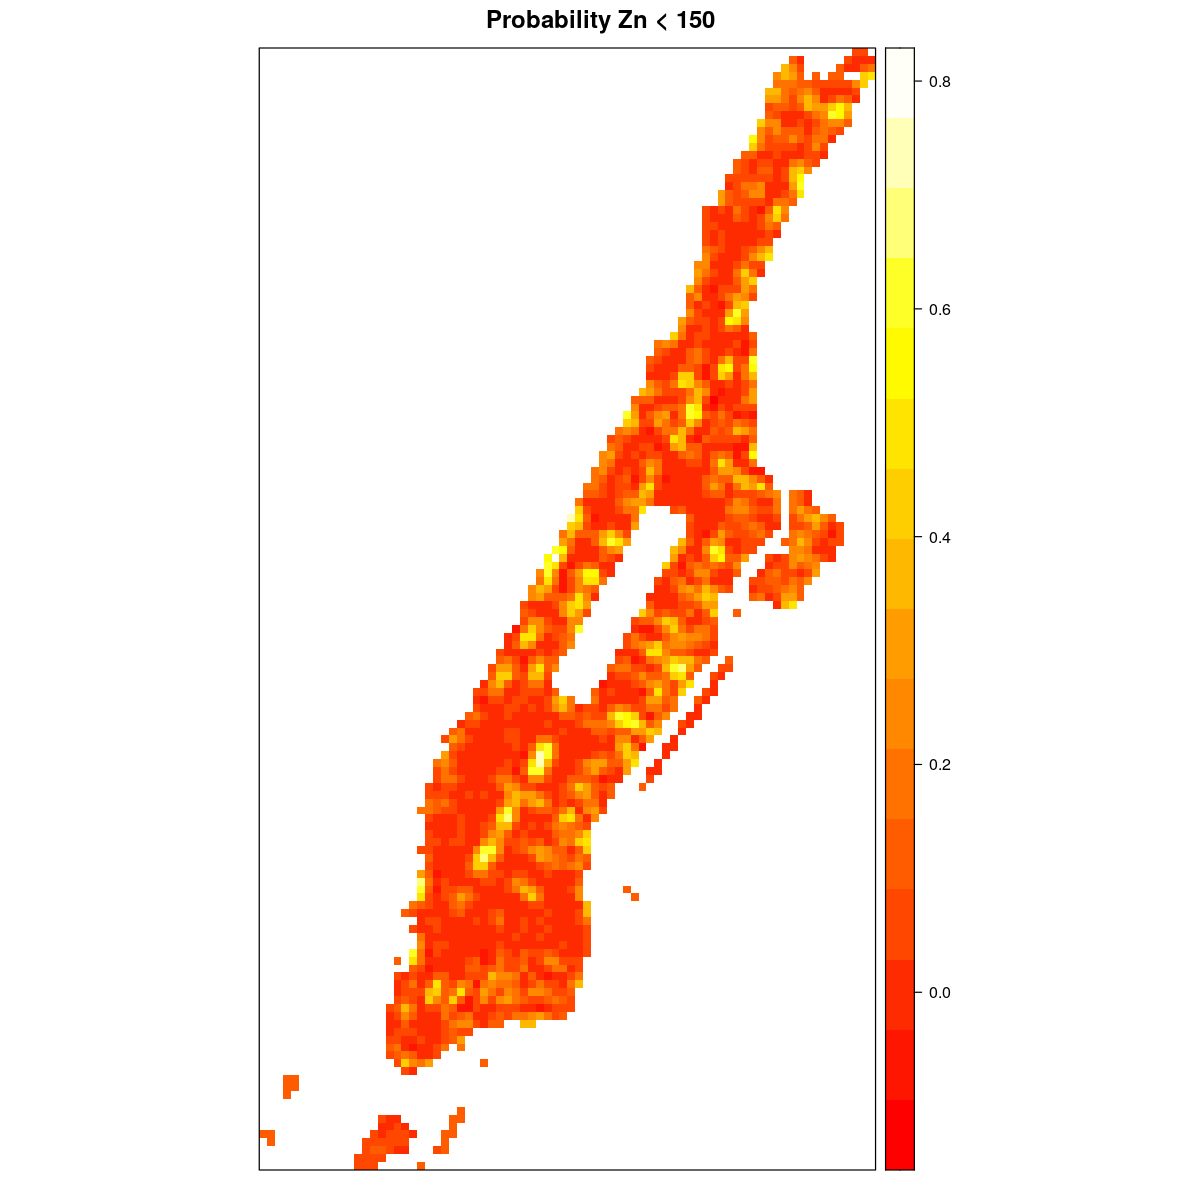

In [185]:
k500.i <- krige(em_i ~ 1, loc = emissionData, newdata =grid_df,model = vimf)
print(spplot(k500.i, zcol = "var1.pred", col.regions = heat.colors(64),
asp = 1, main = "Probability Zn < 150"))

## Discussion
The ordinary kriging results show that there exist higher vehicular emission at the center of the Manhattan midtown and relatively lower emission at lower Manhattan. Although there exist sporadicly locations with relatively higher emission the this borough. This is consistent with the intuition, since relatively speaking other modes of transportation such as Subway or walking are popular at lower Manhattan. While at locations with higher traffic volume with higher speed, the emission is observed to be higher. The prediction plot also highlights the fact that the probability of vehicular emission to be higher than 150 gram is higher at the center of Manhattan Midtown.

## Analyze temporal pattern of emission in New York City
In this step, the temporal pattern of emission at the New York City is analyzed. To do so, emission of all roadway segments are summed and then aggregated at the level of daily and weekly. Then, different autoregression models are estimated.

### Load required libraries

In [242]:
library(dplyr)
library(ggplot2)
library(readr)


Attaching package: 'dplyr'


The following objects are masked from 'package:rgeos':

    intersect, setdiff, union


The following objects are masked from 'package:raster':

    intersect, select, union


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




## Daily emission in New York City

In [248]:
data <- readr::read_csv('/home/sevin/Desktop/projects/emission/data/daily_sum_emission_t.csv')
glimpse(data)


-- Column specification --------------------------------------------------------
cols(
  d = col_double(),
  sum = col_double()
)




Rows: 467
Columns: 2
$ d   <dbl> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, ...
$ sum <dbl> 4007.840, 20422.240, 4674.138, 3719.829, 34269.065, 33087.427, ...


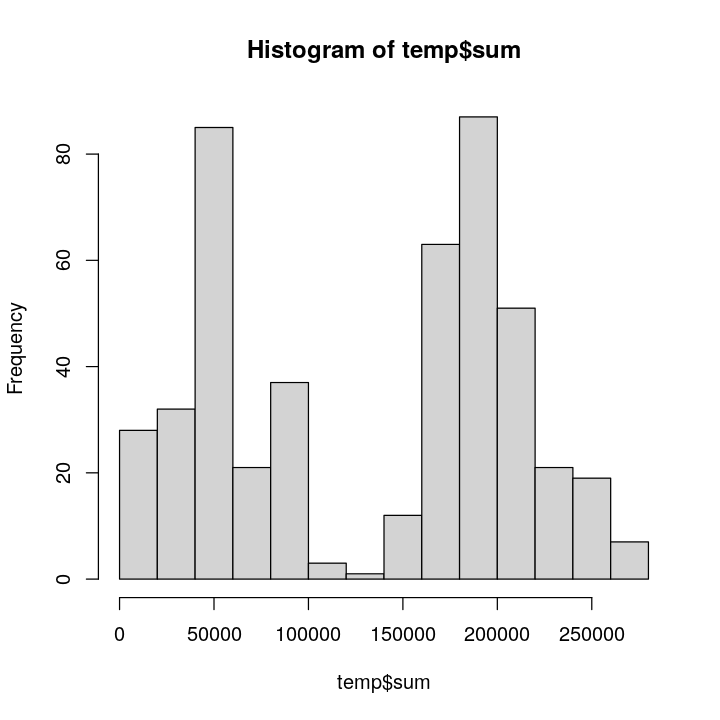

In [249]:
options(repr.plot.width=6, repr.plot.height=6)
hist(temp$sum)

The histogram of the data shows that the total emission in the city has mixure Gaussian Distribution. The autocorrelation plot below shows that the daily total emission has somehow sinosoidal pattern. Therefore, the linear regression model has been estimated using the sine of the emission, square root of the emission, and the emission itself as the explanotary variables. The estimated model could explain the 20% of the variations in the data.


Call:
lm(formula = sum ~ d + sqrt(d) + sin(13.5 * (pi/180) * d), data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-151828  -61374   28766   56011  117991 

Coefficients:
                          Estimate Std. Error t value Pr(>|t|)    
(Intercept)              -49761.24   19462.98  -2.557   0.0109 *  
d                          -654.12     119.62  -5.468 7.44e-08 ***
sqrt(d)                   23275.94    3175.73   7.329 1.04e-12 ***
sin(13.5 * (pi/180) * d)    -29.92    4514.68  -0.007   0.9947    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 68750 on 463 degrees of freedom
Multiple R-squared:  0.2189,	Adjusted R-squared:  0.2139 
F-statistic: 43.26 on 3 and 463 DF,  p-value: < 2.2e-16


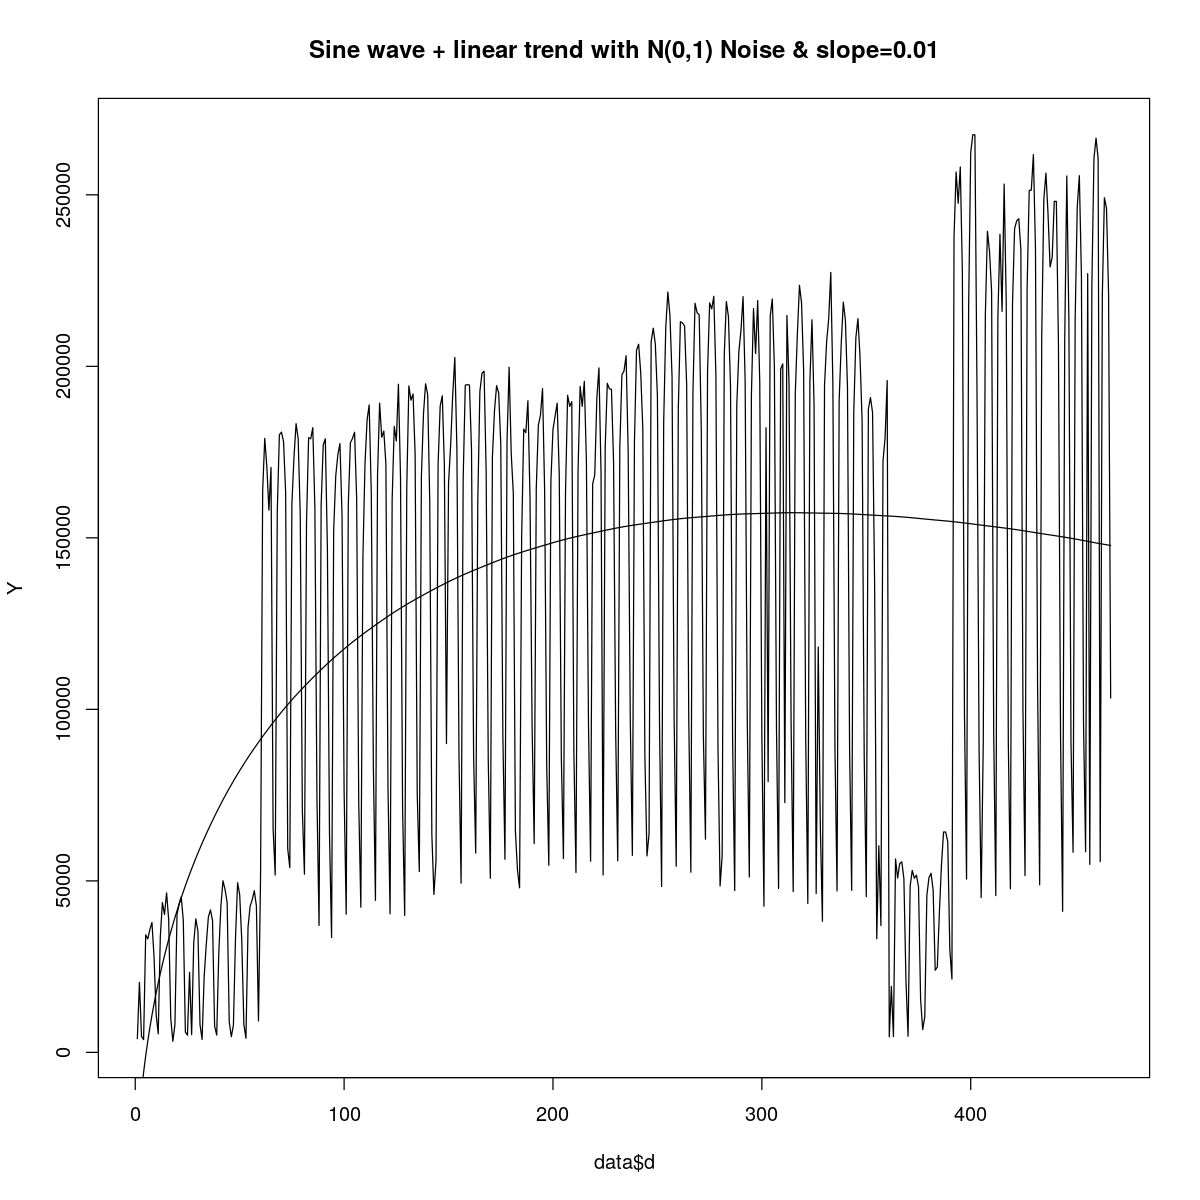

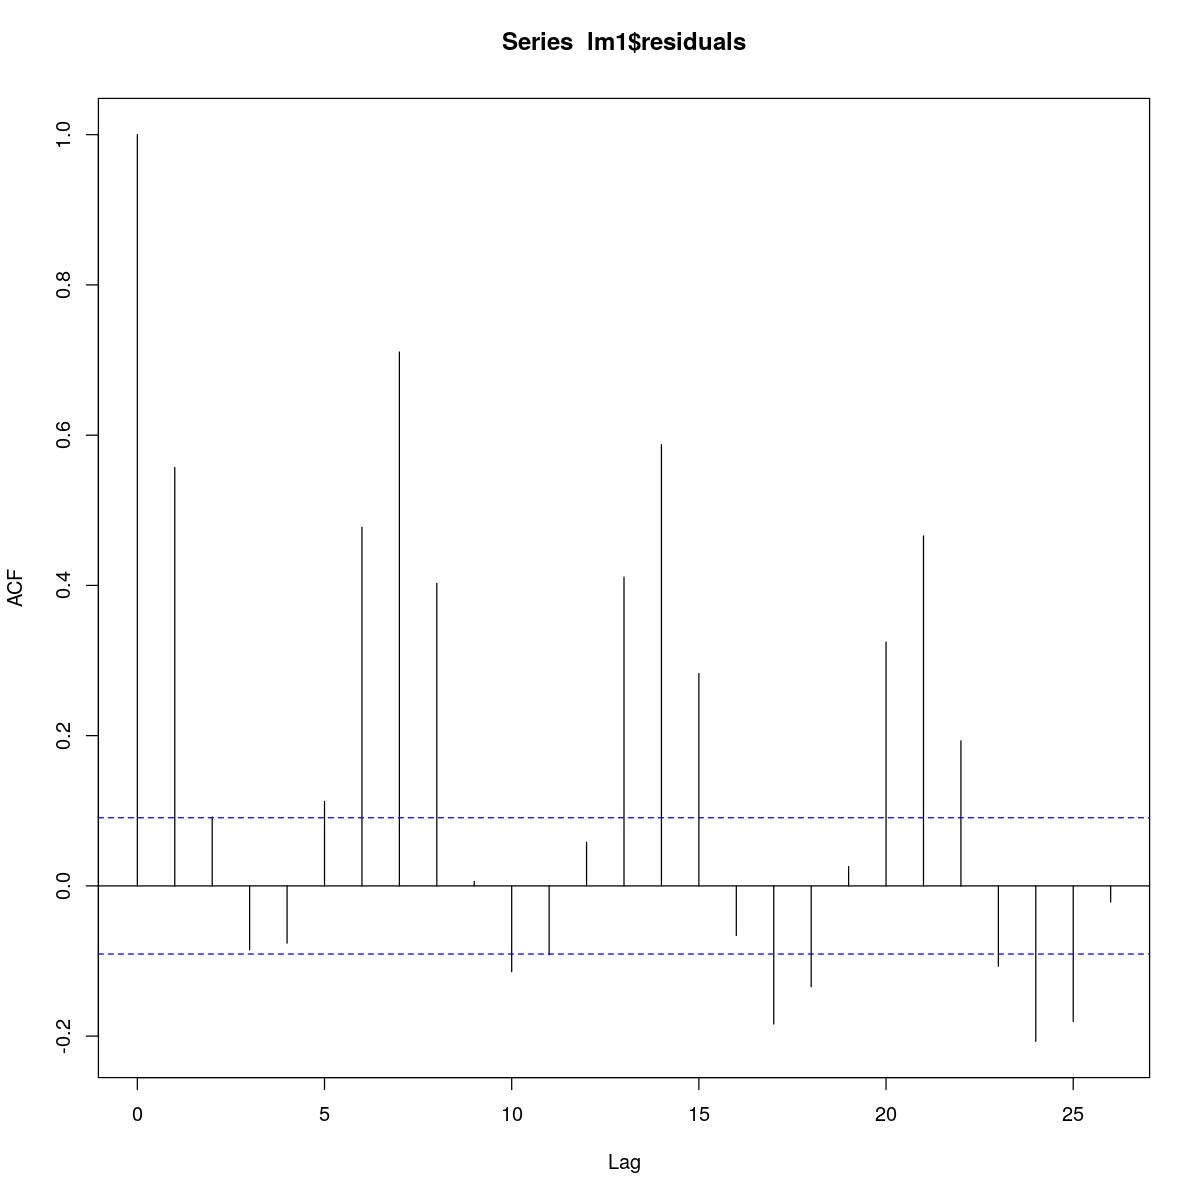

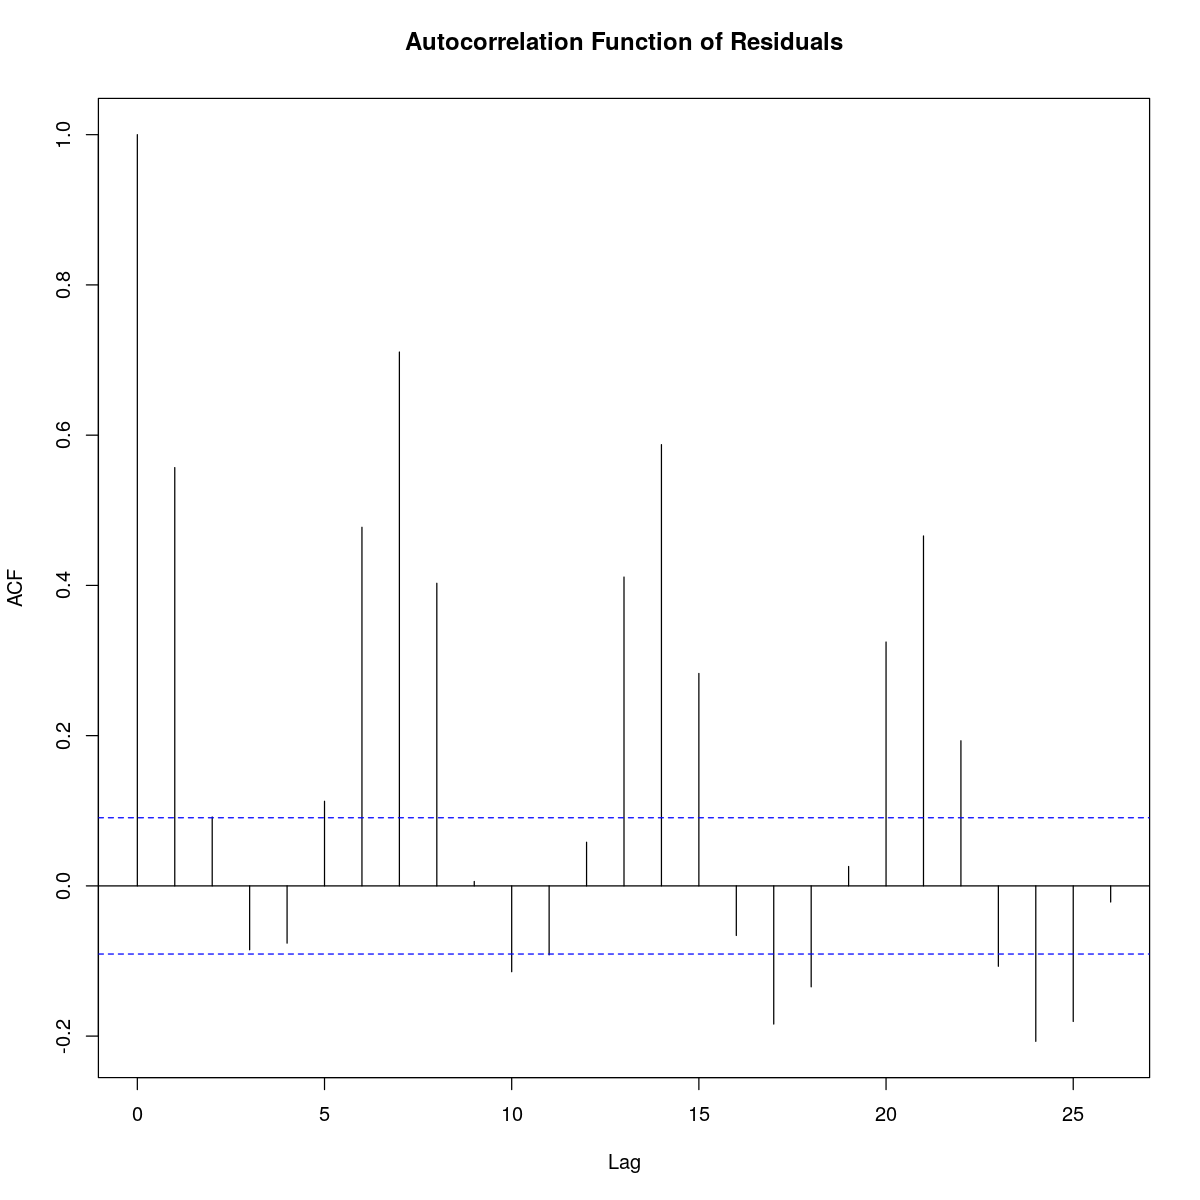

In [251]:
options(repr.plot.width=10, repr.plot.height=10)
lm1 <- lm( sum ~ d + sqrt(d)  + sin(13.5*(pi/180)*d), data=data)
summary(lm1)
plot(data$d,data$sum,main="Sine wave + linear trend with N(0,1) Noise & slope=0.01",ylab="Y",type="l")
lines(data$d, predict(lm1))
plot(acf(lm1$residuals),main="Autocorrelation Function of Residuals" )

## Weekly emission in New York City
In this step, first an autoregression linear model is estimated using the weekly emission data.

In [252]:
data <- readr::read_csv('/home/sevin/Desktop/projects/emission/data/weekly_sum_emission_.csv')


-- Column specification --------------------------------------------------------
cols(
  w = col_double(),
  sum = col_double()
)




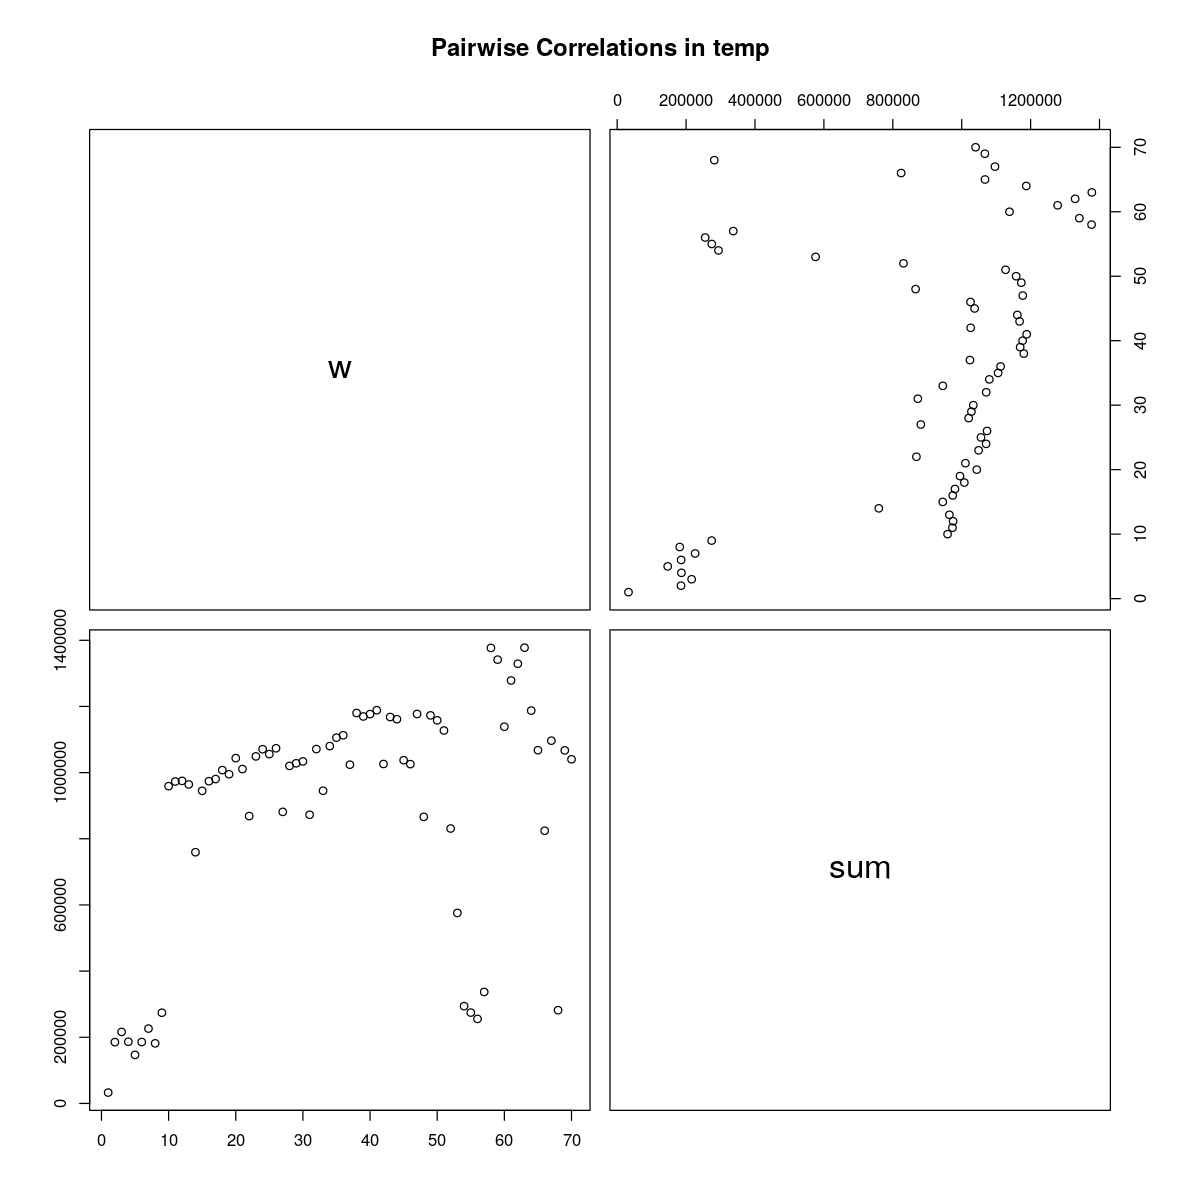

In [253]:
pairs(data, main='Pairwise Correlations in temp')

In [254]:
temp_lag <- data %>%
  mutate(lag_sum = lag(sum, 1)) %>%
  filter(!is.na(lag_sum))
glimpse(temp_lag)

Rows: 69
Columns: 3
$ w       <dbl> 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,...
$ sum     <dbl> 185237.9, 216097.3, 186486.4, 146631.5, 185641.1, 226182.9,...
$ lag_sum <dbl> 32824.05, 185237.90, 216097.30, 186486.39, 146631.55, 18564...



Call:
lm(formula = sum ~ ., data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-847573 -111737  173846  241030  321977 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   623316      80290   7.763  5.9e-11 ***
w               7443       1966   3.786 0.000326 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 332300 on 68 degrees of freedom
Multiple R-squared:  0.1741,	Adjusted R-squared:  0.162 
F-statistic: 14.34 on 1 and 68 DF,  p-value: 0.0003259


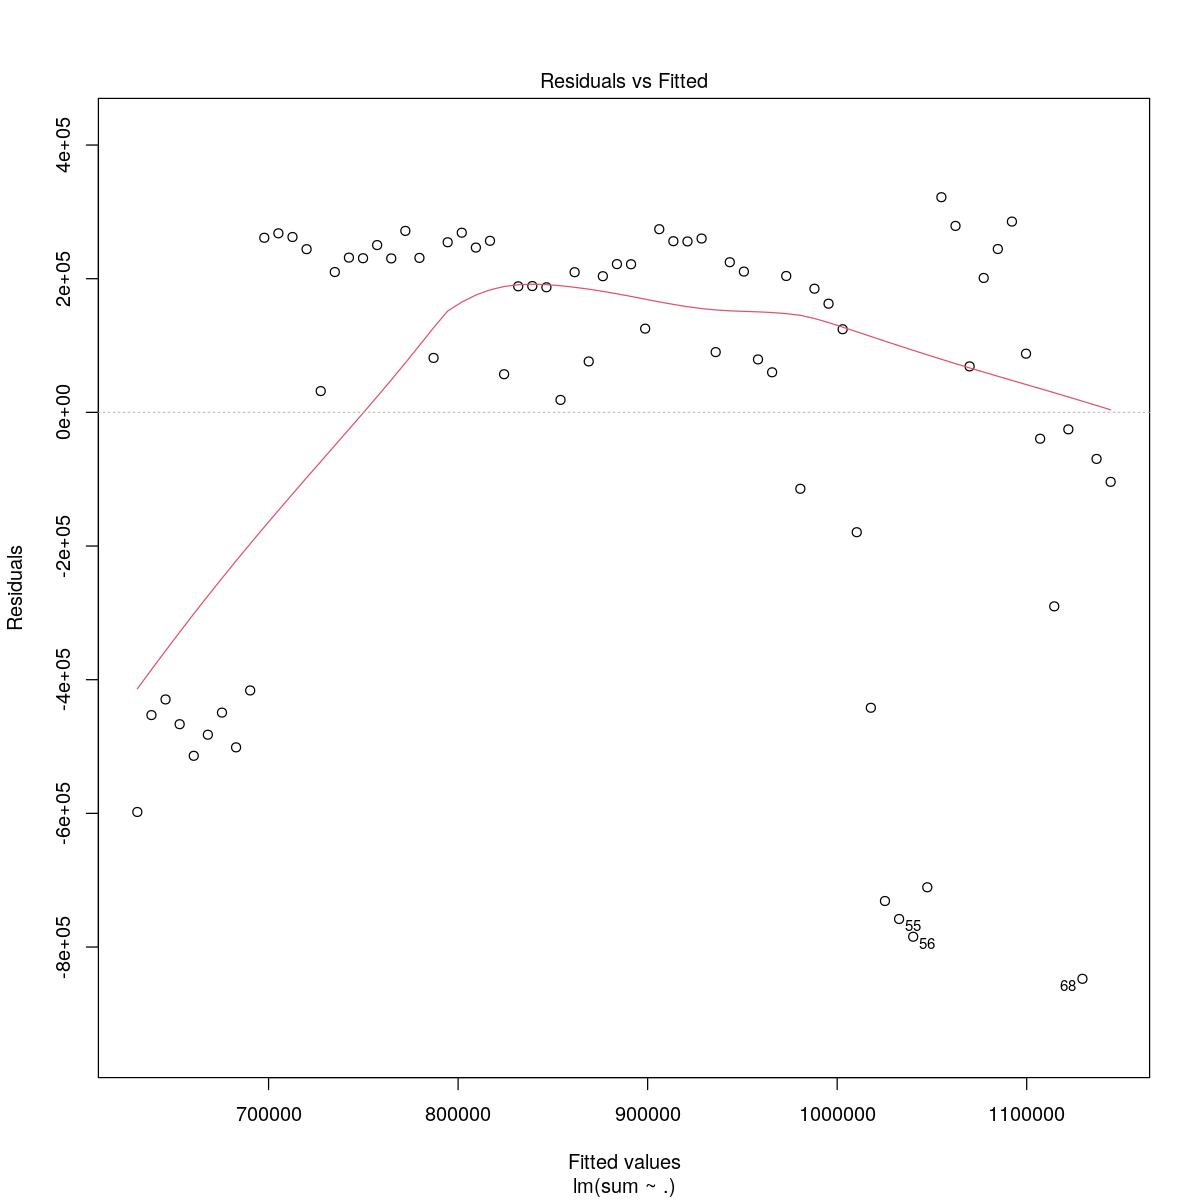

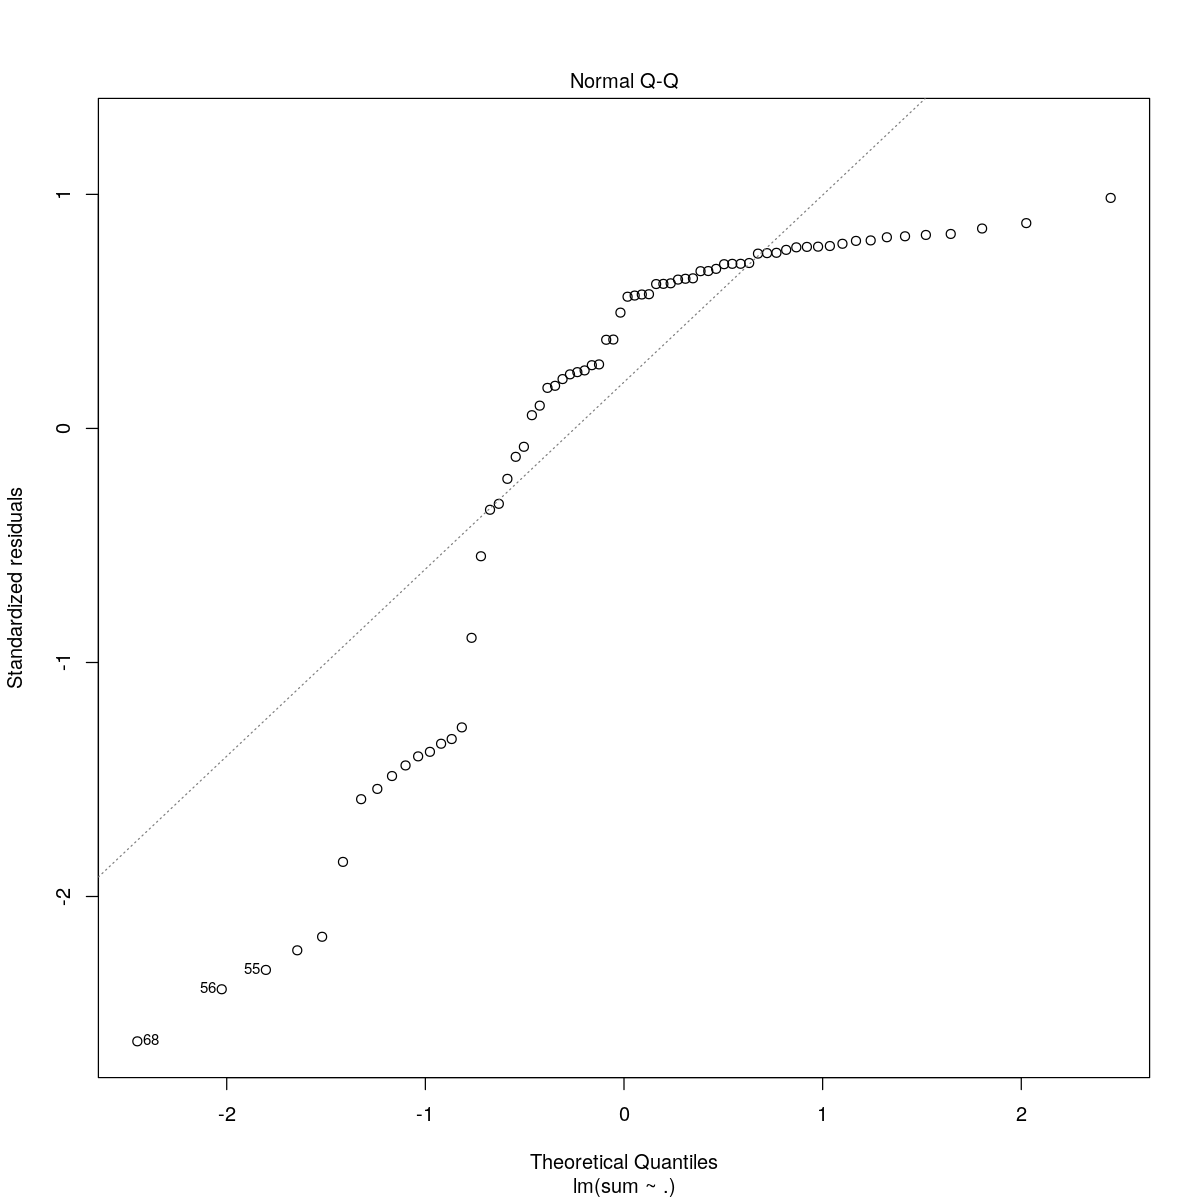

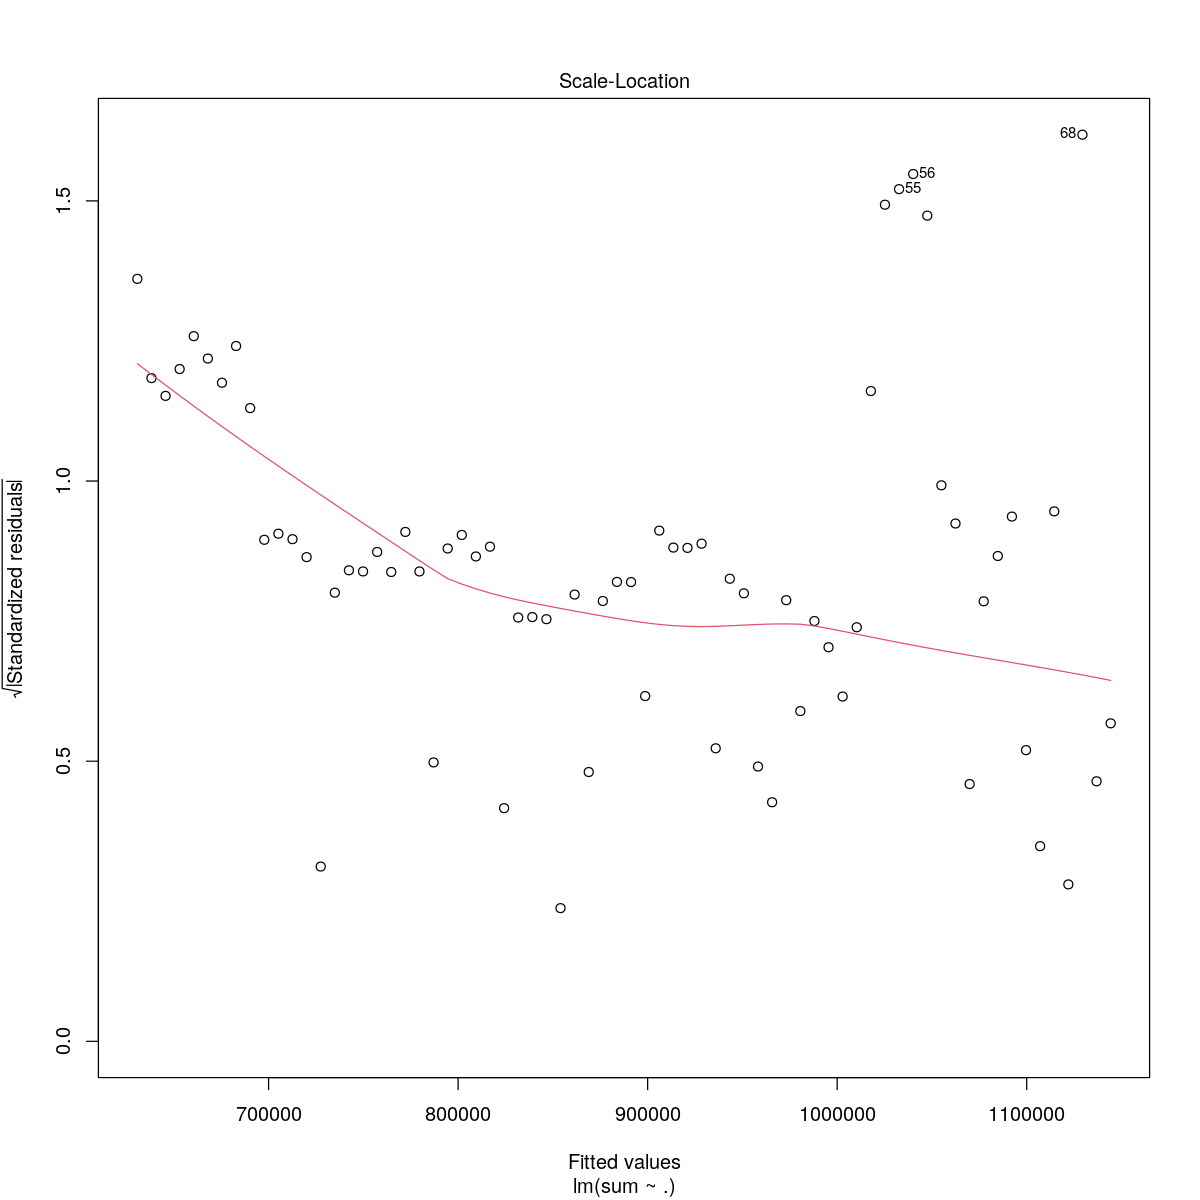

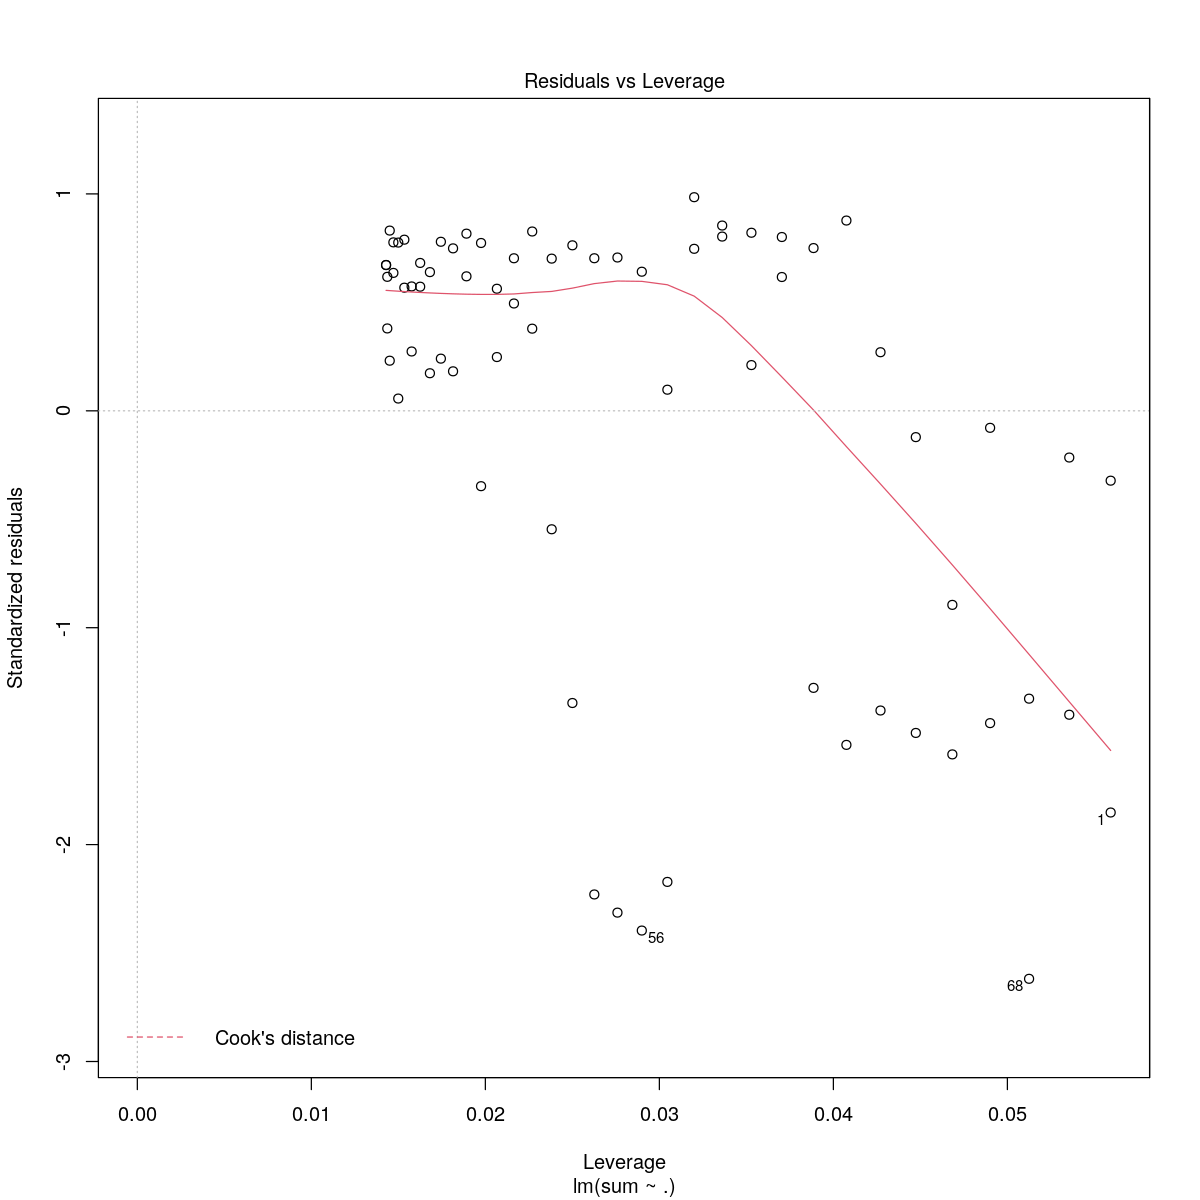

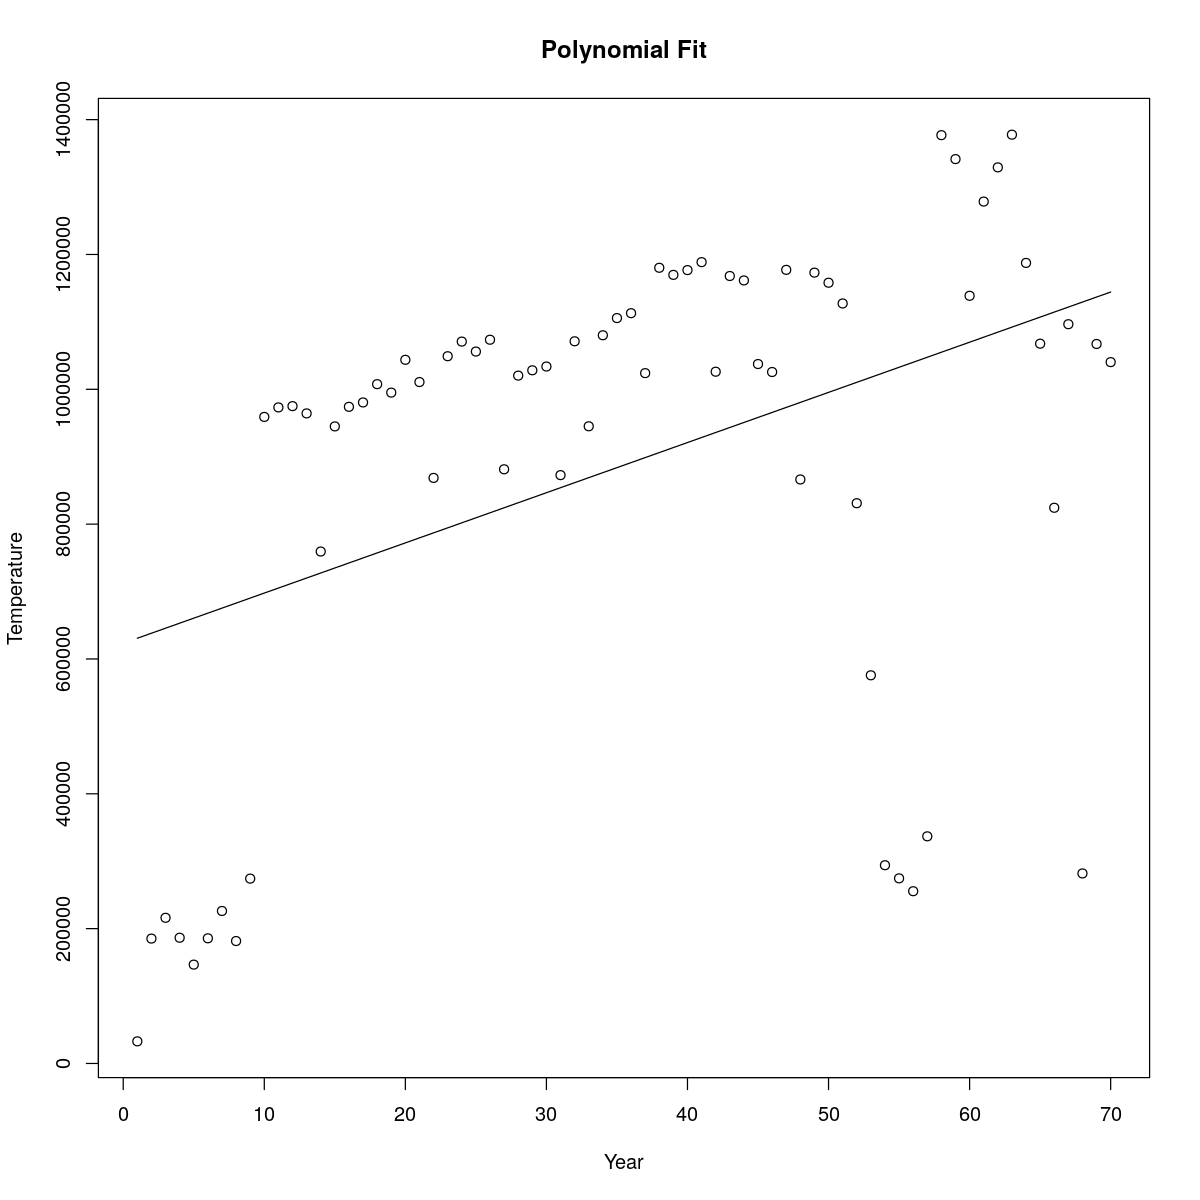

In [255]:
lm1 <- lm( sum ~., data=data)
summary(lm1)
plot(lm1)

plot(data$w, data$sum, xlab="Year", ylab="Temperature", main="Polynomial Fit")
lines(data$w, predict(lm1))

The estimated autoregresiion has the 17% R-squared. Although the plots of residuals do not follow the requirements of the linear regression estimation, i.e., the residuals are  heteroscedastic.

In the next section, the polynomial linear regression is estimated using the emission, and sine of the emission as the other eplanatory variables.. The estimated model explains 42% of the variation in the data which is relatively better than the other estimated models.


Call:
lm(formula = sum ~ w + poly(w, 2, raw = TRUE) + sin(13.5 * (pi/180) * 
    w), data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-754894 -115031   49119  148085  484308 

Coefficients: (1 not defined because of singularities)
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)              249890.7   108607.0   2.301   0.0246 *  
w                         39311.3     7030.2   5.592 4.64e-07 ***
poly(w, 2, raw = TRUE)1        NA         NA      NA       NA    
poly(w, 2, raw = TRUE)2    -450.9       95.7  -4.711 1.31e-05 ***
sin(13.5 * (pi/180) * w) -57280.6    50609.2  -1.132   0.2618    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 282600 on 66 degrees of freedom
Multiple R-squared:  0.4204,	Adjusted R-squared:  0.3941 
F-statistic: 15.96 on 3 and 66 DF,  p-value: 6.611e-08


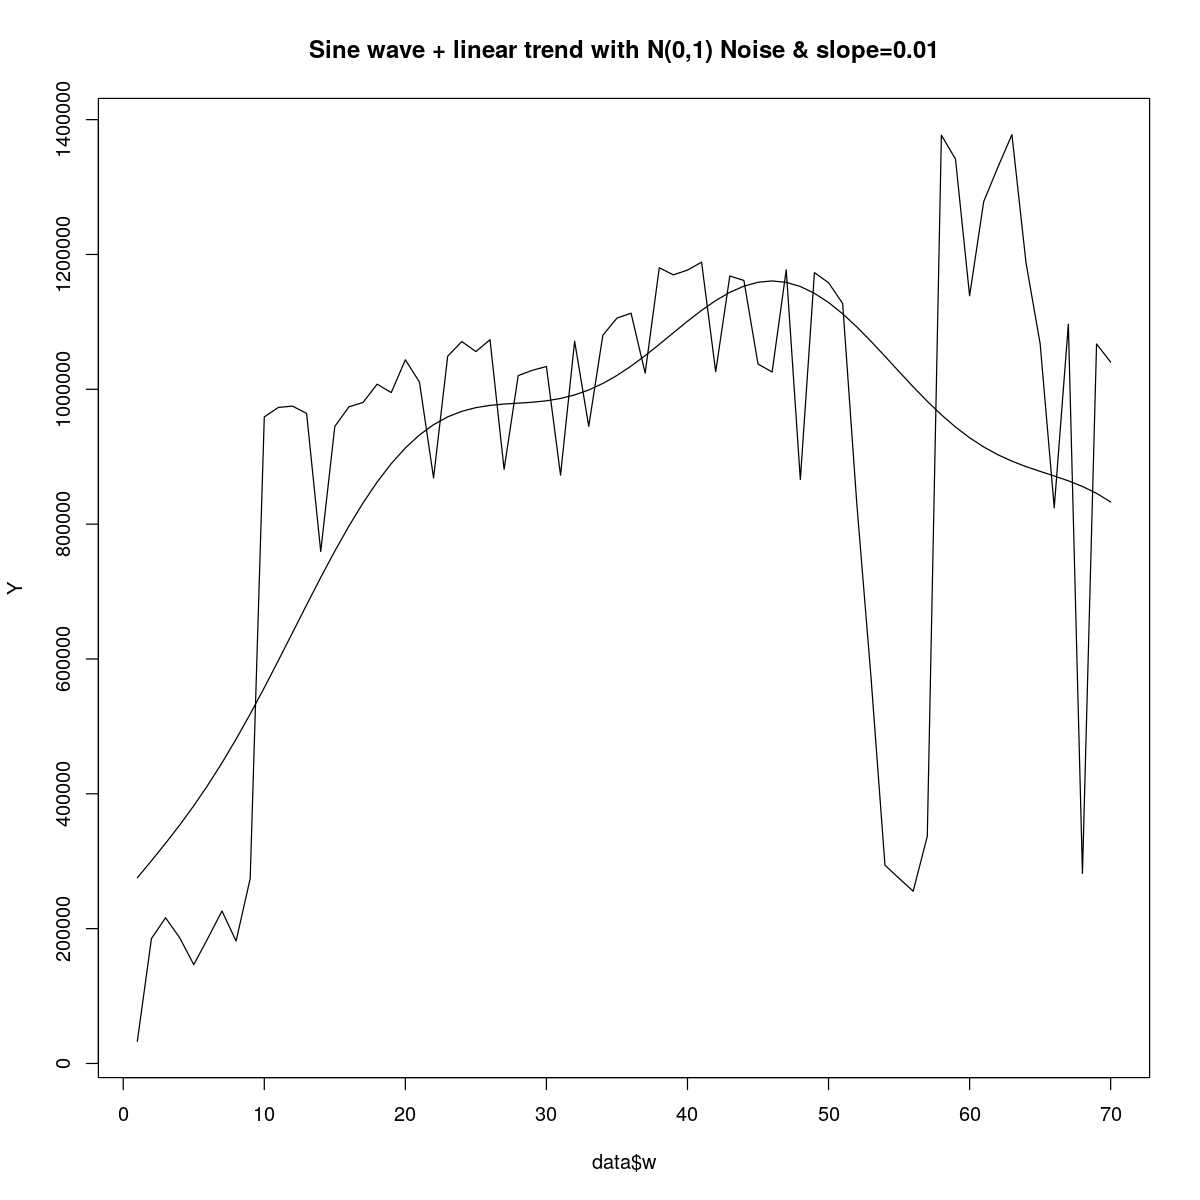

In [256]:
lm1 <- lm( sum ~ w + poly(w, 2, raw=TRUE) + sin(13.5*(pi/180)*w), data=data)
summary(lm1)
plot(data$w,data$sum,main="Sine wave + linear trend with N(0,1) Noise & slope=0.01",ylab="Y",type="l")
lines(data$w, predict(lm1))

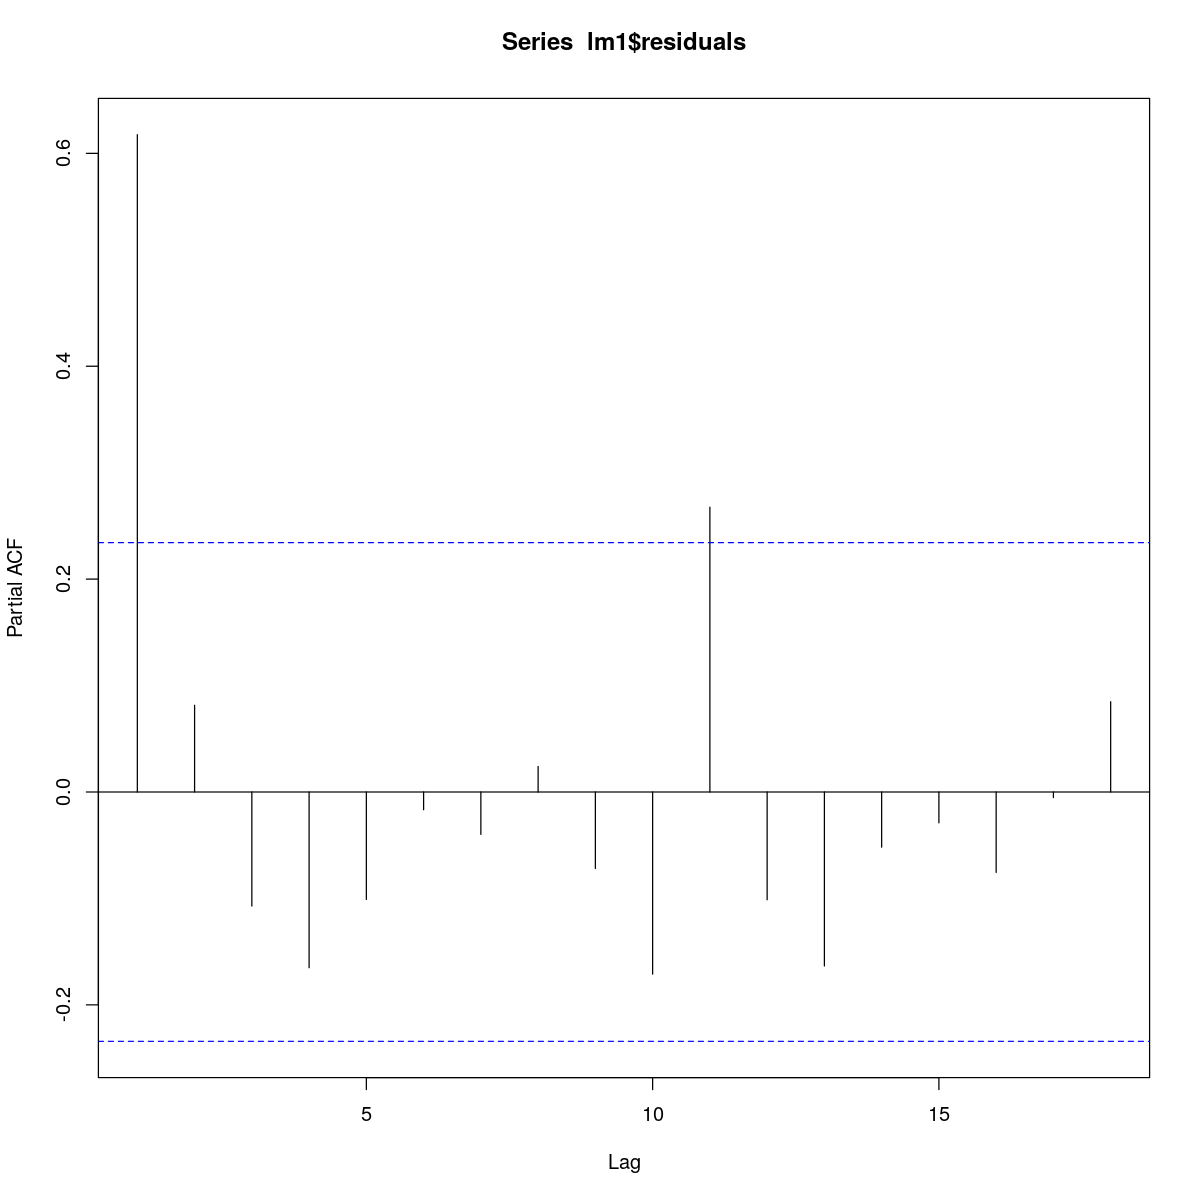

In [257]:
pacf(lm1$residuals)

In the following section, using data of weekly emission in New York City,  a liner regression model is estimated with the emission, root square of emission, and the sine of emission as the explanatory variables. The R-squared of the model is 48%. 


Call:
lm(formula = sum ~ w + sqrt(w) + sin(13.5 * (pi/180) * w), data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-721409  -80713   58575  119627  464194 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)               -581358     220974  -2.631   0.0106 *  
w                          -42412       8678  -4.887 6.85e-06 ***
sqrt(w)                    528550      91018   5.807 1.99e-07 ***
sin(13.5 * (pi/180) * w)   -37409      48072  -0.778   0.4392    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 265700 on 66 degrees of freedom
Multiple R-squared:  0.4874,	Adjusted R-squared:  0.4641 
F-statistic: 20.92 on 3 and 66 DF,  p-value: 1.23e-09


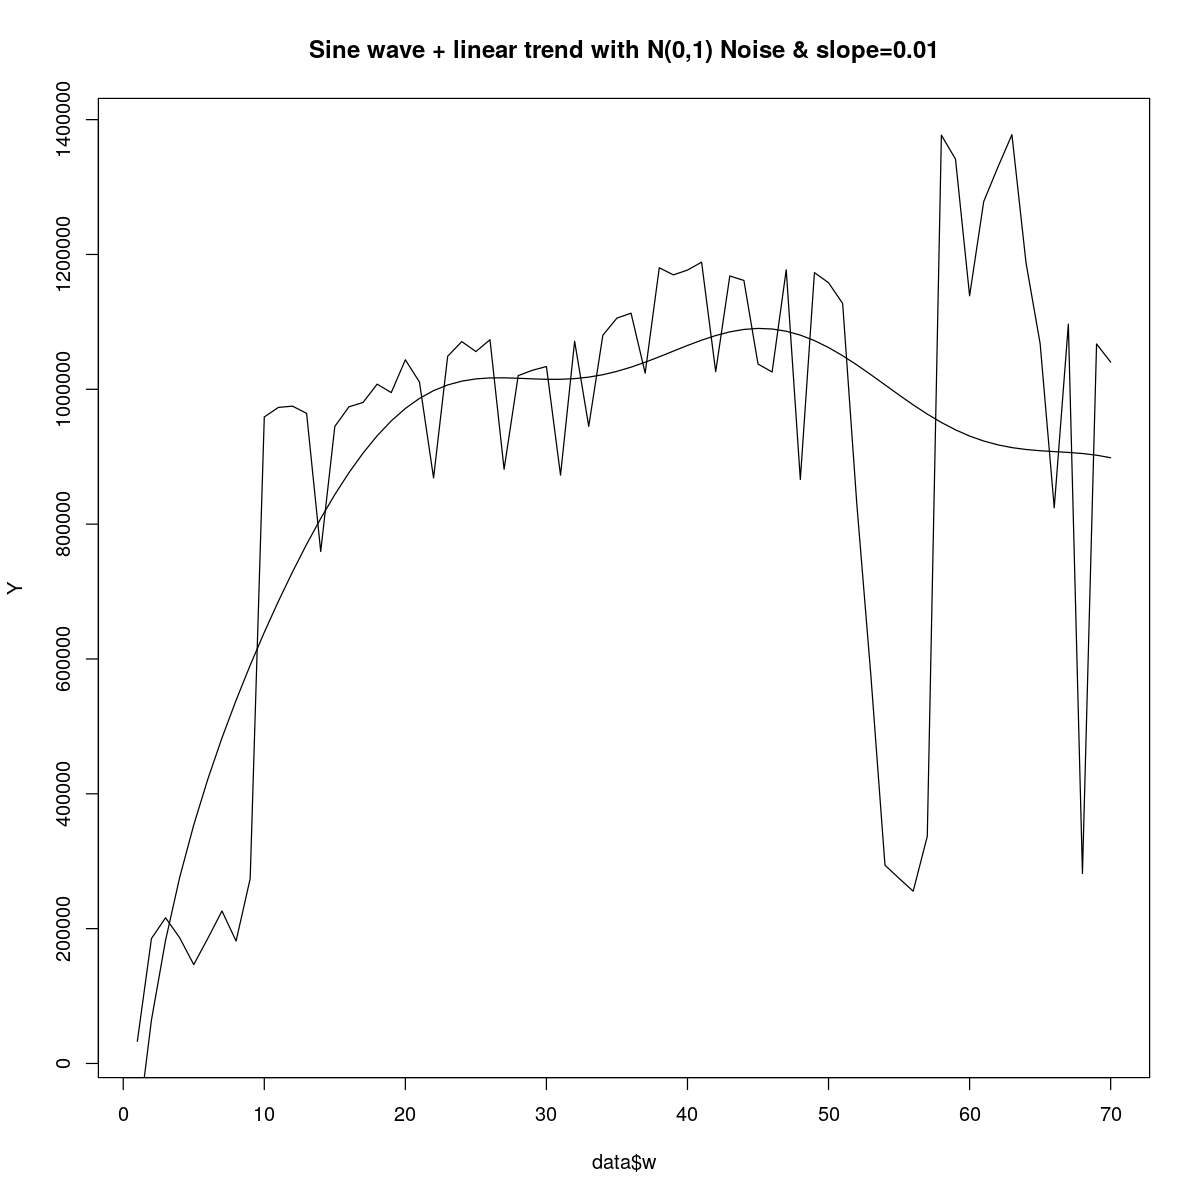

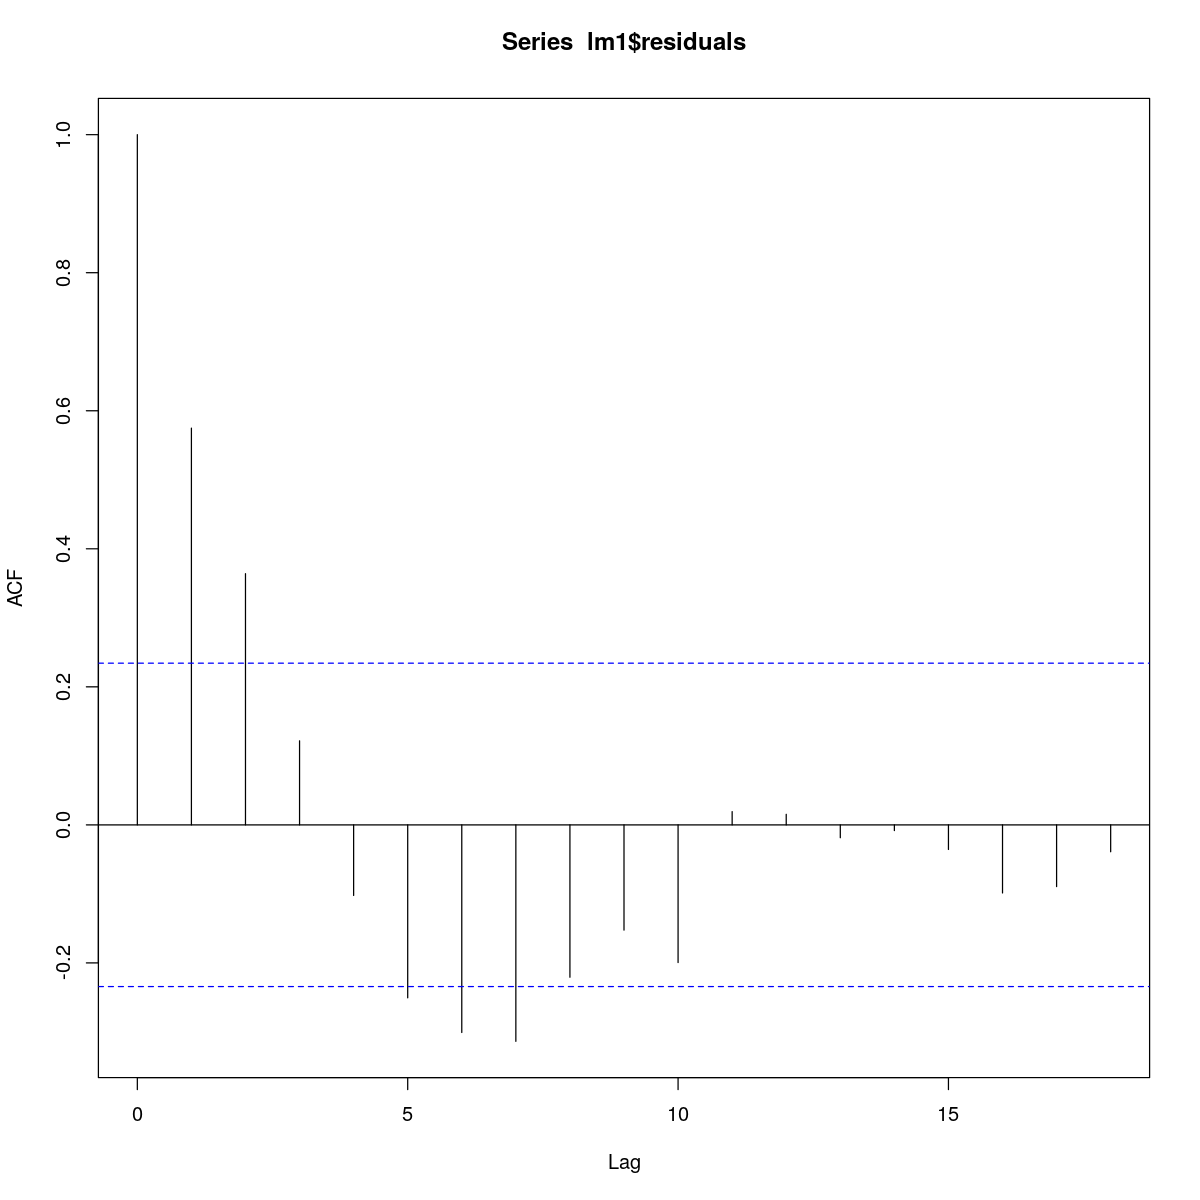

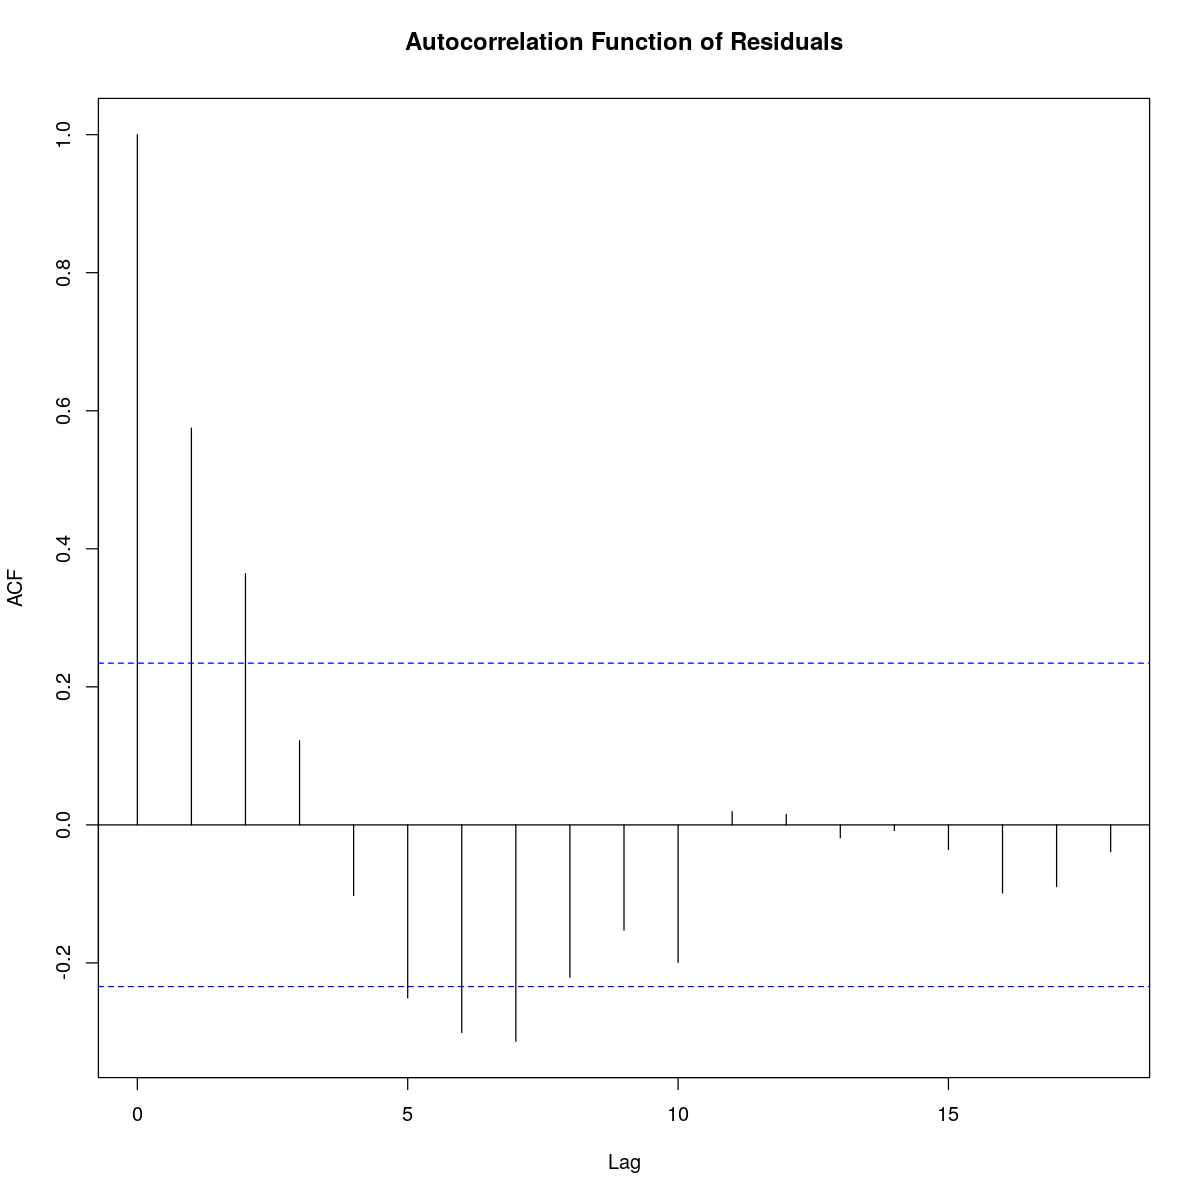

In [258]:
lm1 <- lm( sum ~ w + sqrt(w)  + sin(13.5*(pi/180)*w), data=data)
summary(lm1)
plot(data$w,data$sum,main="Sine wave + linear trend with N(0,1) Noise & slope=0.01",ylab="Y",type="l")
lines(data$w, predict(lm1))
plot(acf(lm1$residuals),main="Autocorrelation Function of Residuals" )

# Conclusion
The aim of this project was to assess the spatial and temporal pattern pf emission in New York City. The GPS trajectory data and COPERT emission model are used for the analysis.  The spatial analysis has been done in two steps, 1. Calculating the semivariances and variograms, and 2. Estimating the kriging model. The results showed that higher emission is centered at the Midtown Manhttan and lower emission has been estimated around Time Square.
To do temporal analysis, different linear regression models as well as the autoregression model are estimated using both daily and weekly emission data in the city. The autocorrelation functions showed that data has sinosoidal pattern. Therefore, at the most of the models, the sine of the emission is considered as the explanatory variable. The R-square of the difefrent models are ranged from 20 to 40 percent.
## Challenges
Working with the large GPS dataset was a big challenge in this project. Preparing the grid was also another challenge since the cordinates in data and polygons needed the approppriate projection. In addition to that, in temporal analysis, the temporal extend of the data was not enough to capture the existing trend in the time series. Besides, data was noisy which requires smoothing techniques before employing temporal statisticl models.

# References
[1] Sui, Y., Zhang, H., Song, X., Shao, F., Yu, X., Shibasaki, R., ... & Li, Y. (2019). GPS data in urban online ride-hailing: A comparative analysis on fuel consumption and emissions. Journal of Cleaner Production, 227, 495-505.

[2] Oliver, M. A., & Webster, R. (2014). A tutorial guide to geostatistics: Computing and modelling variograms and kriging. Catena, 113, 56-69.